# Wrzeciona Snu
Dokładny opis poniższej klasy można znaleźć w folderze raport pod docs.html
Wygenerowany raport można przejrzeć po otworzeniu raport/index.html, gdzie krok po kroku wytłumaczone zostało co zostało wykonane i znajduje się tam pełna dokumentacja klasy signal i klienta.

In [21]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import warnings
import os

class Signal (object):

    def __init__(self, path, Fs):
        '''
        :param path: path to file with signal
        :param Fs:
        '''
        self.path = path
        self.s = np.fromfile(path, dtype='float32')
        self.T = len(self.s)/Fs
        self.Fs = Fs
        self.nyq_f = Fs / 2
        self.t = np.arange(0, self.T, 1 / Fs)
        self.window = Fs * 20

    def plot_signal(self, show = True):
        '''
        :param show:
        :return:
        '''
        plt.figure(figsize=((20, 10)))
        plt.plot(self.t[:self.window], self.s[:self.window])
        plt.title("Signal Windowed 0s - {}s".format(int(self.window/self.Fs)))
        plt.xlabel("Time (s)")
        plt.ylabel("Signal Value")
        if show:
            print("Okienkowany Sygnał\n" + "Przedstawienie sygnału okienkowanego prostokątnie na przedziale 0s - {}s.\n Reprezentuje jedną składkę EEG.".format(int(self.window/self.Fs)))
            plt.show()
            

    def filt_classifier(self, verbose = True):
        '''
        :param verbose:
        :return:
        '''

        def charkterystyki(a, b, f, T, Fs, name):
            t = np.arange(-T, T, 1 / Fs)
            w = 2 * np.pi * f / Fs
            w, h = ss.freqz(b, a, w)

            faza = np.unwrap(np.angle(h))
            df = np.diff(faza)
            df = np.hstack((df, 0))
            idx, = np.where(np.abs(df - np.pi) < 0.05)
            df[idx] = (df[idx + 1] + df[idx - 1]) / 2
            df = df[:-1]
            grupowe = - df / np.diff(w)
            opoznienieFazowe = - faza / w

            fig = plt.figure()
            plt.subplot(3, 2, 1)
            plt.title('moduł transmitancji')
            m = np.abs(h)
            plt.plot(f, 20 * np.log10(m))
            plt.ylabel('[dB]')

            plt.subplot(3, 2, 3)
            plt.title('opóźnienie fazowe')
            plt.plot(f, opoznienieFazowe)
            plt.ylabel('próbki')

            plt.subplot(3, 2, 5)
            plt.title('opóźnienie grupowe')
            plt.plot(f[:-1], grupowe)
            plt.ylabel('próbki')
            plt.xlabel('Częstość [Hz]')
            plt.ylim([0, np.max(grupowe) + 1])

            plt.subplot(3, 2, 2)
            plt.title('odpowiedź impulsowa')
            x = np.zeros(len(t))
            x[len(t) // 2] = 1
            y = ss.lfilter(b, a, x)
            plt.plot(t, x)
            plt.plot(t, y)
            plt.xlim([-T / 2, T])

            plt.subplot(3, 2, 4)
            plt.title('odpowiedź schodkowa')
            s = np.zeros(len(t))
            s[len(t) // 2:] = 1
            ys = ss.lfilter(b, a, s)  # przepuszczamy impuls przez filtr i obserwujemy odpowiedź impulsową
            plt.plot(t, s)
            plt.plot(t, ys)
            plt.xlim([-T / 2, T])
            plt.xlabel('Czas [s]')

            fig.subplots_adjust(hspace=.5)
            plt.show()

        print("Metoda Filtrowania")

        # FIRST FILTERING
        N = 7
        Wn = (11 / self.nyq_f, 16 / self.nyq_f)
        [b, a] = ss.butter(N, Wn, btype='bandpass')
        if verbose:
            print("Charakterystyka pierwszego filtru")
            charkterystyki(a, b, np.arange(0.01,self.nyq_f,0.01), self.T, self.Fs, "first")
        s_1 = ss.filtfilt(b, a, self.s)
        s_1 *= s_1

        # SHOW SIGNAL AFTER FILTERING IF VERBOSE
        if verbose:
            plt.figure(figsize=((20, 10)))
            plt.plot(self.t[:self.window], s_1[:self.window])
            plt.title("Signal after bandpass 11 - 16Hz\nWindowed: 0s - {}s".format(int(self.window/self.Fs)))
            plt.xlabel("Time (s)")
            print("Przeflitrowany sygnał I\n" +  
                         u"Przedstawienie sygnału okienkowanego prostokątnie na przedziale 0s - {}s. Sygnał został przefiltrowany filtrem pasmowym z częstościami odcięcia 11 Hz i 16 Hz i następnie podniesiony do kwadratu".format(
                             int(self.window / self.Fs)))
            plt.show()

        # SECOND FILTERING
        N = 7
        Wn = 10 / self.nyq_f
        [b, a] = ss.butter(N, Wn, btype='lowpass')
        if verbose:
            print("Charakterystyka drugiego filtru")
            charkterystyki(a, b, np.arange(0.01, self.nyq_f, 0.01), self.T, self.Fs, "second")
        s_2 = ss.filtfilt(b, a, s_1)
        s_2 = s_2 ** .5

        # SHOW SIGNAL AFTER FILTERING IF VERBOSE
        if verbose:
            plt.figure(figsize=((20, 10)))
            plt.plot(self.t[:self.window], s_2[:self.window])
            plt.title("Signal after bandpass 11 - 16Hz and lowpass 10Hz\nWindowed: 0s - {}s".format(int(self.window / self.Fs)))
            plt.xlabel("Time (s)")
            print("Przeflitrowany sygnał II\n" +
                         u"Przedstawienie sygnału okienkowanego prostokątnie na przedziale 0s - {}s. Sygnał został przefiltrowany filtrem dolnoprzepustowym z częstościami odcięcia 10 Hz, następnie wyciągnięto z niego pierwiastek".format(
                             int(self.window / self.Fs)))
            plt.show()

        # FIND ALL ABOVE 5 mV
        s_2[s_2 < 5] = 0
        s_2[s_2 >= 5] = 1

        # SHOW SIGNAL AFTER BINARY TRANSFORM IF VERBOSE
        if verbose:
            plt.figure(figsize=((20, 10)))
            plt.plot(self.t[:self.window], s_2[:self.window])
            plt.title("Signal after binary mapping 5 mV\nWindowed: 0s - {}s".format(int(self.window / self.Fs)))
            plt.xlabel("Time (s)")
            print("Sygnał przemapowany 0/1 \nPrzedstawienie sygnału okienkowanego prostokątnie na przedziale 0s - {}s. Sygnał został przemapowany na wartości 0 i 1, gdzie 0 reprezentuje wartości mniejsze niż 5 mV, a 1 wartości większe niż 5 mV".format(int(self.window / self.Fs)))
            plt.show()

        min_t = 0.5
        min_elements = int(min_t * self.Fs)

        length = len(s_2) - min_elements
        spindle = []
        for i in range(0, length):
            total = np.sum(s_2[i:i + min_elements])
            ratio = total / min_elements
            if ratio == 1:
                spindle.append(i)

        prev = spindle[0]
        filt_spindles = [spindle[0]]
        for w in spindle:
            if w - prev > 1:
                filt_spindles.append(prev + min_elements - 1)
                filt_spindles.append(w)
            prev = w
        filt_spindles.append(spindle[-1] + min_elements - 1)
        filt_spindles = np.array(filt_spindles)
        shape = filt_spindles.shape[0]
        filt_spindles = filt_spindles.reshape(int(shape / 2), 2)
        if verbose:
            print("{:<10}||{:>10}".format("Start", "End"))
            print(22*"=")
            for i in filt_spindles:
                print("{:<10}||{:>10}".format(i[0], i[1]))
        # the array has at pointer 0 the start point and pointer 1 the end point
        # Transform to time
        filt_spindles = filt_spindles / self.Fs
        print("\n"+22*"="+"\n\n\n\n\n\n")
        return np.array(filt_spindles)  # [t_start, t_end]

    def mp_classifier(self, max_iteration, energy_error, verbose = True):
        '''
        :param max_iteration:
        :param energy_error:
        :param verbose:
        :return:
        '''
        print("Metoda MP")

        def parametry_atomu(book, atom):
            f_Hz = atom['params']['f'] * book.fs / 2  # przekodowujemy częstość atomu na częstość w Hz
            A = atom['params']['amplitude']  # odczytujemy amplitudę
            phase = atom['params']['phase']  # odczytujemy fazę
            t0 = atom['params']['t'] / book.fs  # przeliczamy pozycję atomu z wartości w próbkach na wartości w sek.
            scale = atom['params']['scale'] / book.fs  # szerokość atomu w timeie (w sek.)
            return f_Hz, A, phase, t0, scale

        def tfr_atomu(book, atom, N_czestosci):
            f_Hz, A, phase, t0, scale = parametry_atomu(book, atom)
            t = np.arange(0, book.epoch_s / book.fs, 1 / book.fs)
            f = np.linspace(0, Fs / 2, N_czestosci)
            rec_t = np.zeros((1, book.epoch_s))
            rec_f = np.zeros((N_czestosci, 1))
            rec_t[0, :] = np.exp(-np.pi * ((t - t0) / scale) ** 2)  # obliczamy obwiednię timeową -> dla f. Gabora jest to f. Gaussa
            rec_f[:, 0] = np.exp(-np.pi * ((f - f_Hz) * scale) ** 2)  # obliczamy obwiednię częstotliwościową -> dla f. Gabora jest to f. Gaussa
            tfr_atom = np.kron(rec_t,
                               rec_f)  # przemnażamy przez siebie obwiednie -> to jest reprezentacja time-częstość pojedynczego atomu
            tfr_atom /= np.sum(np.sum(tfr_atom))  # normalizujemy
            tfr_atom *= atom['params']['modulus'] ** 2  # skalujemy energię
            return t, f, tfr_atom

        def rekonstrukcja_atomu(book, atom):
            f_Hz, A, phase, t0, scale = parametry_atomu(book, atom)
            t = np.arange(0, book.epoch_s / book.fs, 1 / book.fs)
            rekonstrukcja = A * np.exp(-np.pi * ((t - t0) / scale) ** 2) * np.cos(
                2 * np.pi * f_Hz * (t - t0) + phase)  # obliczamy przebieg timeowy atomu (funkcja Gabora) i
            return t, rekonstrukcja

        def TFRPlot(TFR, t_mapy, f_mapy, sig, Fs=128, title=''):
            '''
            Funkcja do rysowania map time-częstość z sygnałem zaprezentowanym poniżej
            TFR - mapa time-częstość (time-freqyency representation
            t_mapy, f_mapy - wektory reprezentujące osie timeu i częstości
            sig - sygnał do wyrysowania pod mapą (np. ten, z którego powstała mapa)
            Fs - częstość próbkowania sygnału
            title - tytuł do wyświetlenia ponad mapą
            '''
            df = f_mapy[1] - f_mapy[0]
            dt = t_mapy[1] - t_mapy[0]
            t = t_mapy
            plt.figure(figsize=(20, 10))
            sygAxes = plt.axes([0.05, 0.05, 0.8, 0.1])
            tfAxes = plt.axes([0.05, 0.15, 0.8, 0.8])
            sygAxes.plot(t, sig)
            plt.xlim((t_mapy.min(), t_mapy.max()))
            tfAxes.imshow(TFR, aspect='auto', origin='lower', interpolation='nearest',
                          extent=(
                          t_mapy.min() - dt / 2, t_mapy.max() + dt / 2, f_mapy.min() - df / 2, f_mapy.max() + df / 2))
            plt.setp(tfAxes, xticklabels=[])
            plt.title(title)
            if np.sum(TFR):
                print("Epoka " + title.split(' ')[-1] + 
                         "\nPrzedstawienie sygnału w przestrzeni czas częstość na przedziale {}s - {}s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz".format(str(np.round(t_mapy.min())), str(np.round(t_mapy.max()))))
                plt.show()
            plt.clf()

        signal_file = self.path
        config_file = './mp_classify_config.set'
        Fs = self.Fs
        probes_per_epoch = self.Fs * 20 
        no_channels = 1
        selected_channels = 1  # wybrane kanały:
        #     a) numerowane są od 1
        #     b) składnia wybierania: 1, 3, 5, 7-11, 19
        no_epochs = int(len(self.s)/probes_per_epoch)
        selected_epochs = "1-{}".format(no_epochs)  # które epoki analizować, składnia wyboru tak jak dla kanałów

        maxIteracji = max_iteration  # liczba iteracji do wykonania dla jednej epoki, chyba,
        # że wcześniej zostanie osiągnięty zadany poniżej

        procentEnergii = 95.  # procent wyjaśnionej energii
        energyError = energy_error  # parametr regulujący gęstość słownika float w zakresie 0-1.
        # odpowiada minimalnej odległości między atomami słownika mierzonej w metryce iloczynów scalernych
        # nierówności (7) w cytowanym art.
        # Czym mniejszy tym większy słownik i tym dokładniejsza dekompozycja
        algorytm = 'SMP'  # możliwe wartości SMP | MMP1 |MMP2 |MMP3 - algorytmy opisane w art.

        # powyższe ustawiena zapisujemy do pliku tekstowego:
        fo = open(config_file, "wt")
        fo.write('# OBLIGATORY PARAMETERS\n')
        fo.write('nameOfDataFile  ' + signal_file + '\n')
        fo.write('nameOfOutputDirectory  ./\n')
        fo.write('writingMode            CREATE \n')  #
        fo.write('samplingFrequency      ' + str(Fs) + '\n')
        fo.write('numberOfChannels       ' + str(no_channels) + '\n')
        fo.write('selectedChannels       ' + str(selected_channels) + '\n')
        fo.write('numberOfSamplesInEpoch ' + str(probes_per_epoch) + '\n')
        fo.write('selectedEpochs         ' + str(selected_epochs) + '\n')
        fo.write('typeOfDictionary       OCTAVE_FIXED\n')
        fo.write('energyError            ' + str(energyError) + ' 100.0 \n')
        fo.write('randomSeed             auto \n')
        fo.write('reinitDictionary       NO_REINIT_AT_ALL \n')
        fo.write('maximalNumberOfIterations ' + str(maxIteracji) + '\n')
        fo.write('energyPercent             ' + str(procentEnergii) + '\n')
        fo.write('MP                        ' + algorytm + '\n')
        fo.write('scaleToPeriodFactor       1.0 \n')
        fo.write('pointsPerMicrovolt        1.0 \n')

        fo.write('\n# ADDITIONAL PARAMETERS\n')
        fo.write('normType                  L2 \n')
        fo.write(
            'diracInDictionary         YES \n')  # ta i poniższe linie włączają odpowiednie typy funkcji do słownika
        fo.write('gaussInDictionary         YES \n')
        fo.write('sinCosInDictionary        YES \n')
        fo.write('gaborInDictionary         YES \n')
        fo.close()

        bookName = self.path.split('.bin')[0] + '_smp.b'
        print("There is an input box, if you are using jupyter then it most propably showed higher up")
        rerun = input("{} already exists, do you want to re run MP? [Y/N]".format(bookName))
        if rerun.lower() == "y":
            print("Rerunning MP")
            status = os.system('./empi-osx64 ' + config_file)
            if status == 32512:
                raise Exception("Cannot find empi executable, status code: {}".format(status))
            elif status != 0:
                raise Exception("Error at MP, status code: {}".format(status))
        else:
            print("Calculating Atoms")
        try:
            from book_reader import BookImporter
        except:
            warnings.warn('MISSING BOOK READER') # Throw Error
        bookName = self.path.split('.bin')[0]+'_smp.b'
        book = BookImporter(bookName)
        N_czestosci = int(book.fs)
        epoki = range(1, 31)  # Posłuży on nam do odtwarzania poszczególnych atomów
        total = 0
        mp_spindles = []
        for numerEpoki in epoki:
            rekonstrukcja = np.zeros(book.epoch_s)  # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
            mapaEnergii = np.zeros(
                (N_czestosci, book.epoch_s))  # Przygotowujemy tablicę, w której powstanie reprezentacja time-częstość.
            for atom in book.atoms[numerEpoki]:  # iterujemy się po atomach danej epoki
                f_Hz, A, phase, t0, scale = parametry_atomu(book, atom)
                t_mp, atom_time = rekonstrukcja_atomu(book, atom)
                t_mp, f, atom_tfr = tfr_atomu(book, atom, N_czestosci)
                if f_Hz > 11 and f_Hz < 16 and scale >= 0.5:
                    total += 1
                    mapaEnergii += atom_tfr
                    rekonstrukcja += atom_time
                    t_start = t0 + (numerEpoki - 1) * 20 - scale / 2
                    t_end = t0 + (numerEpoki - 1) * 20 + scale / 2
                    mp_spindles.append([t_start, t_end])
            t_mp += (numerEpoki - 1) * 20
            if verbose: TFRPlot(mapaEnergii, t_mp, f, rekonstrukcja, Fs=128, title="{} epoka: {}".format(self.path.split('bin')[0], numerEpoki))
        if verbose:
            print("{:<10}||{:>10}".format("Start", "End"))
            print(22*"=")
            for i in mp_spindles:
                print("{:<10.2f}||{:>10.2f}".format(i[0], i[1]))
        print("\n"+22*"="+"\n\n\n\n\n\n")
        return mp_spindles

Metoda Filtrowania
Charakterystyka pierwszego filtru


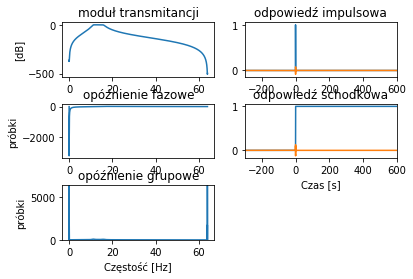

Przeflitrowany sygnał I
Przedstawienie sygnału okienkowanego prostokątnie na przedziale 0s - 20s. Sygnał został przefiltrowany filtrem pasmowym z częstościami odcięcia 11 Hz i 16 Hz i następnie podniesiony do kwadratu


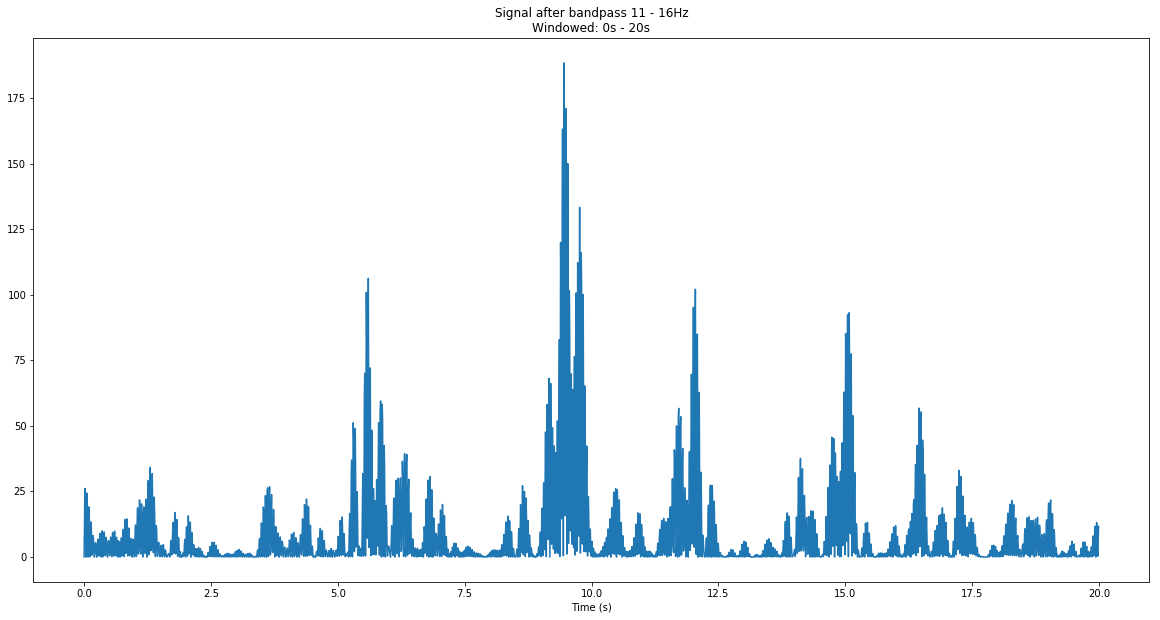

Charakterystyka drugiego filtru


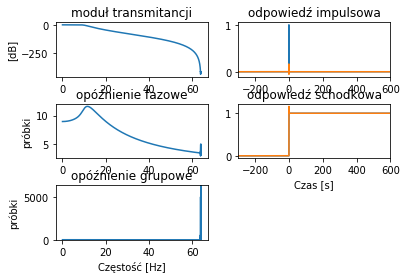

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in sqrt


Przeflitrowany sygnał II
Przedstawienie sygnału okienkowanego prostokątnie na przedziale 0s - 20s. Sygnał został przefiltrowany filtrem dolnoprzepustowym z częstościami odcięcia 10 Hz, następnie wyciągnięto z niego pierwiastek


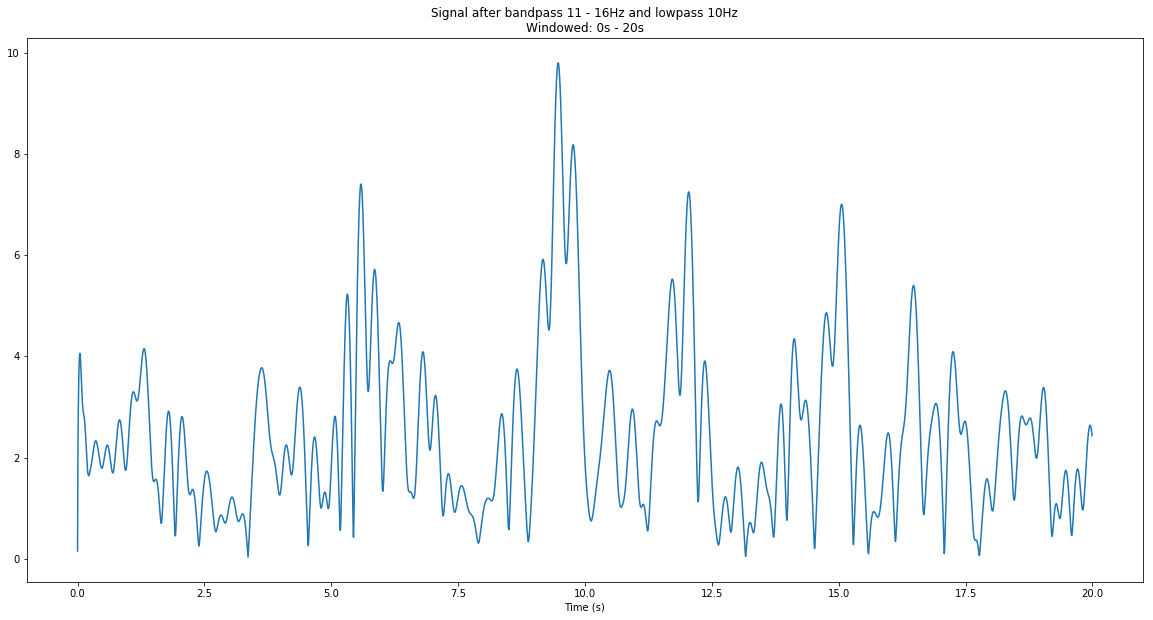

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in greater_equal


Sygnał przemapowany 0/1 
Przedstawienie sygnału okienkowanego prostokątnie na przedziale 0s - 20s. Sygnał został przemapowany na wartości 0 i 1, gdzie 0 reprezentuje wartości mniejsze niż 5 mV, a 1 wartości większe niż 5 mV


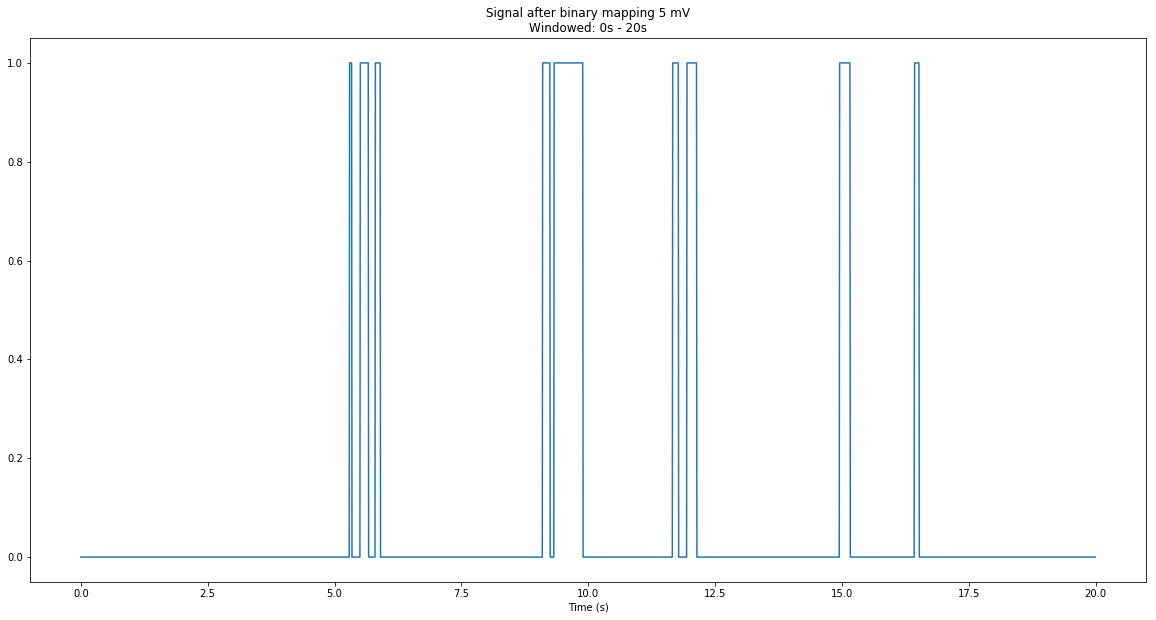

Start     ||       End
1194      ||      1266
13110     ||     13175
15165     ||     15252
16711     ||     16790
28392     ||     28456
30003     ||     30066
39280     ||     39391
42359     ||     42448
45149     ||     45256
45583     ||     45661
45898     ||     45999
47190     ||     47257
48931     ||     49043
49931     ||     49995
50608     ||     50678
54439     ||     54519
58598     ||     58665
62708     ||     62779
64466     ||     64534
65056     ||     65119
69362     ||     69430
70679     ||     70750
74835     ||     74944







Metoda MP
There is an input box, if you are using jupyter then it most propably showed higher up
./inb14_fragment_smp.b already exists, do you want to re run MP? [Y/N]n
Calculating Atoms
Epoka 1
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 0.0s - 20.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


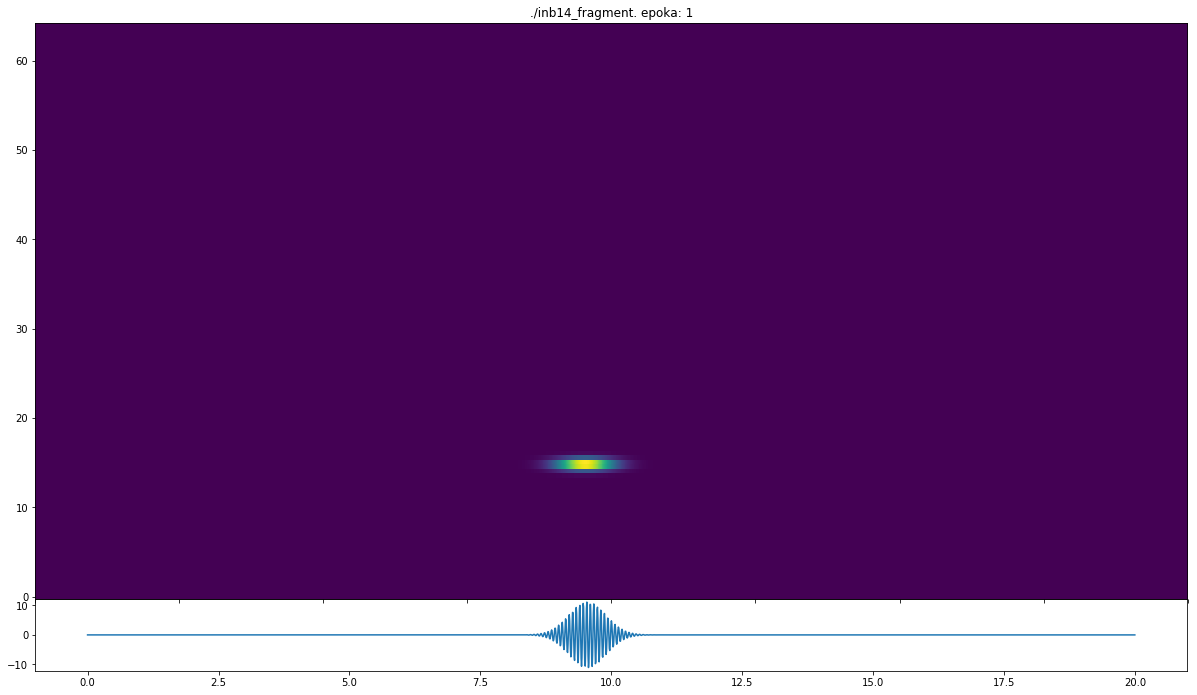

Epoka 2
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 20.0s - 40.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


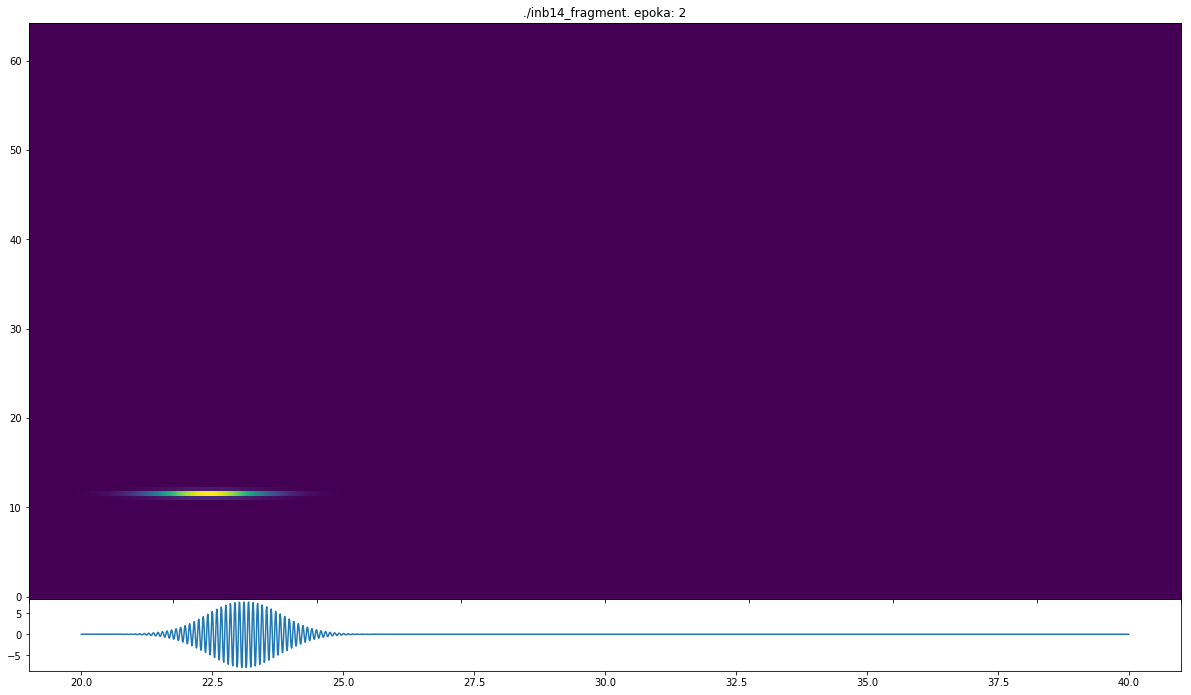

Epoka 4
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 60.0s - 80.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


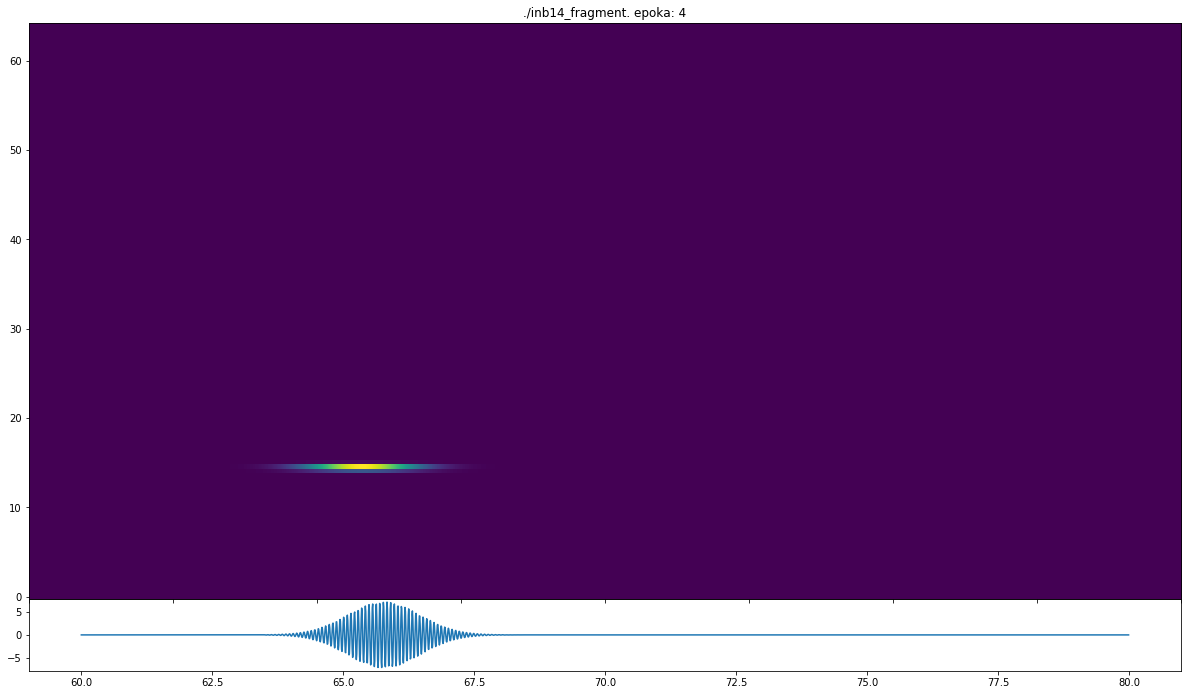

Epoka 6
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 100.0s - 120.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


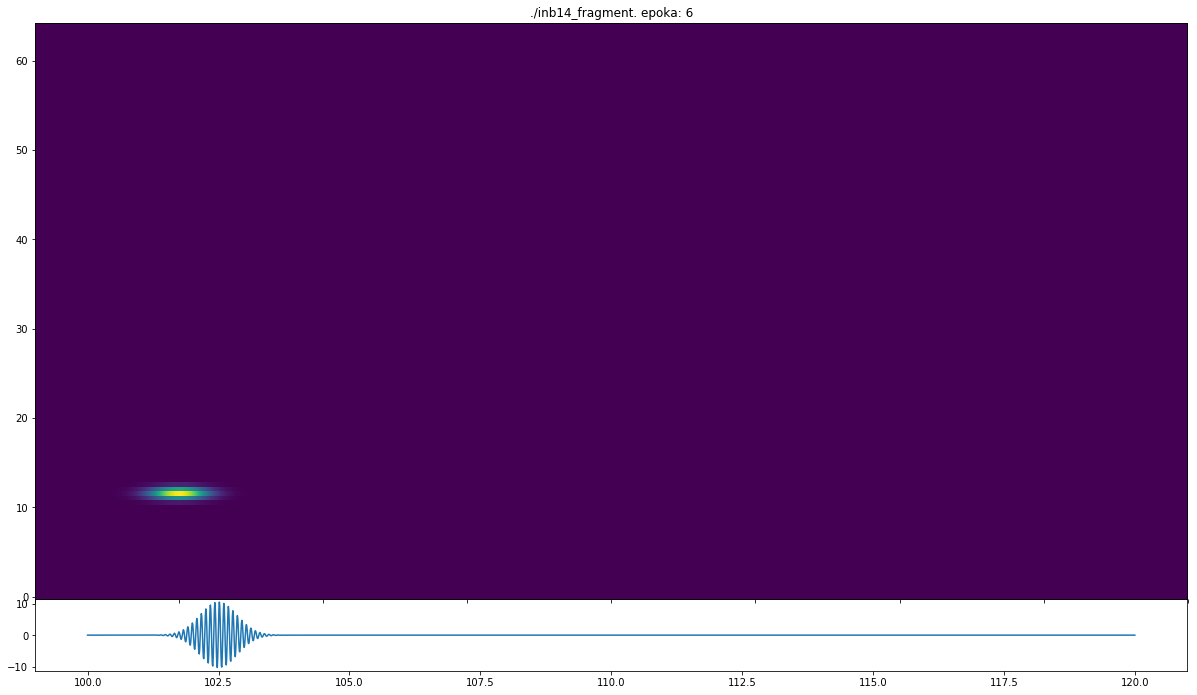

Epoka 16
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 300.0s - 320.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


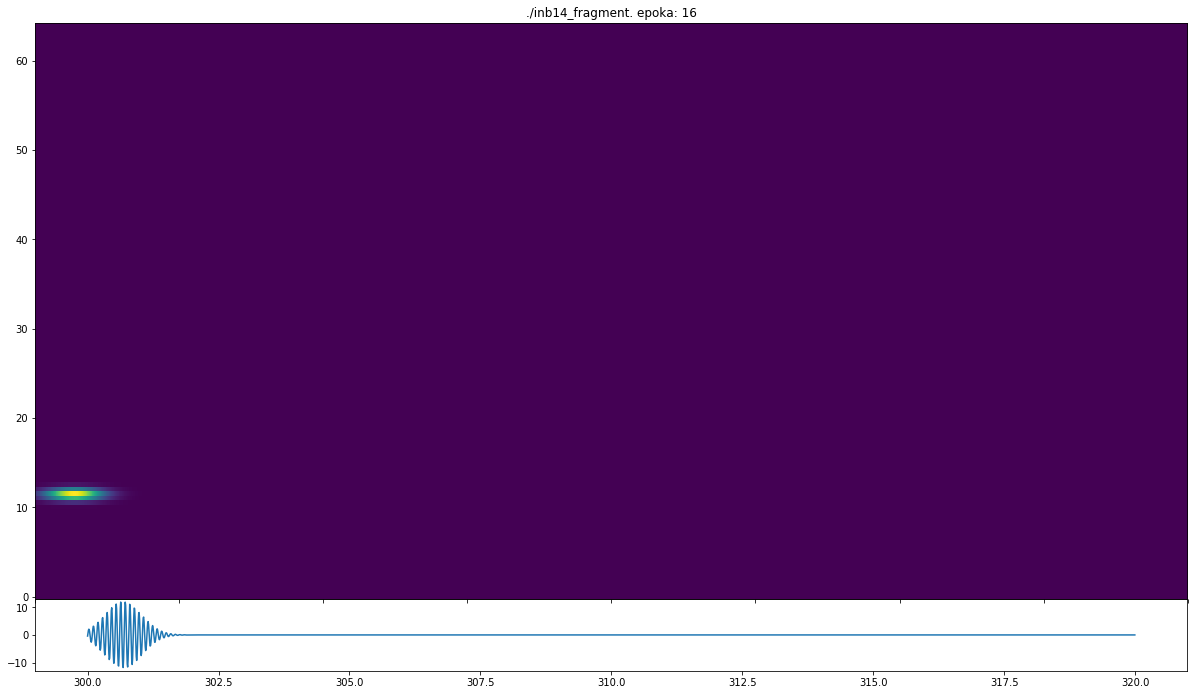

Epoka 18
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 340.0s - 360.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


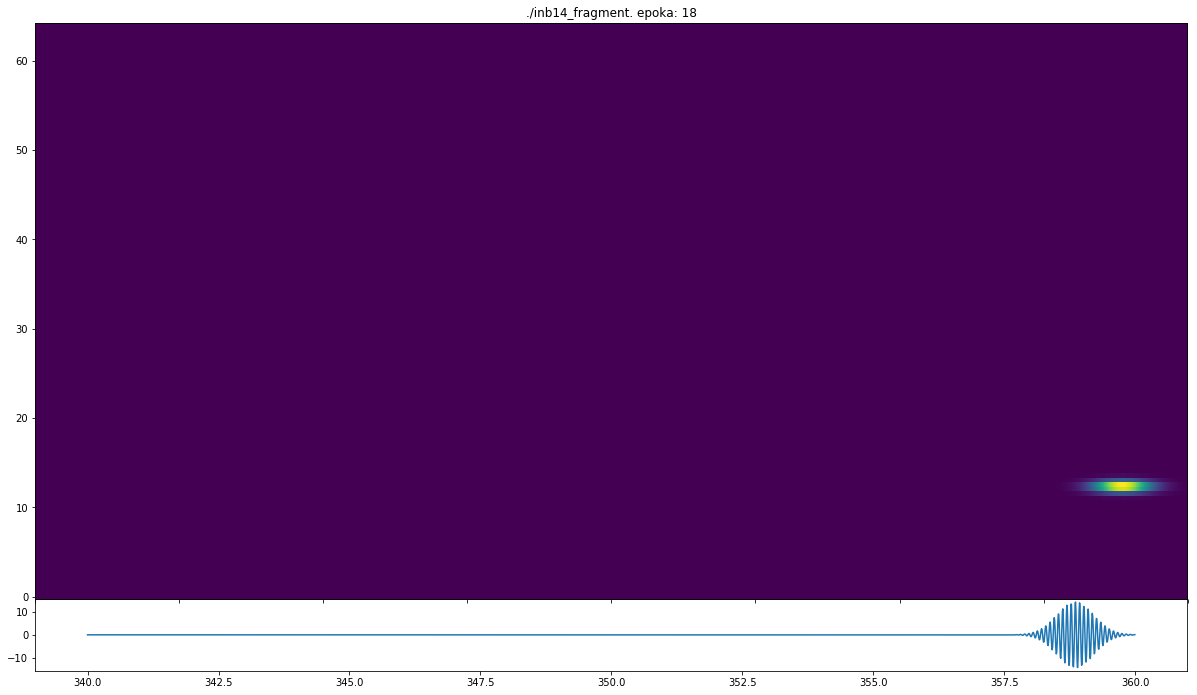

Epoka 20
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 380.0s - 400.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


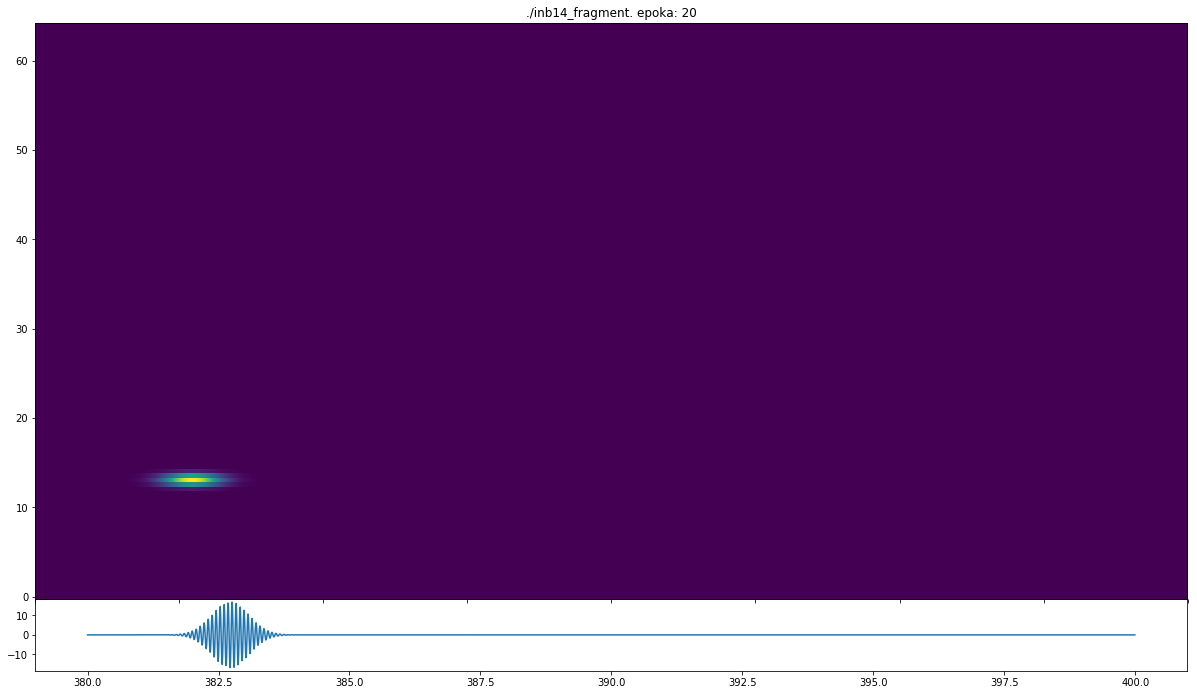

Epoka 27
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 520.0s - 540.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


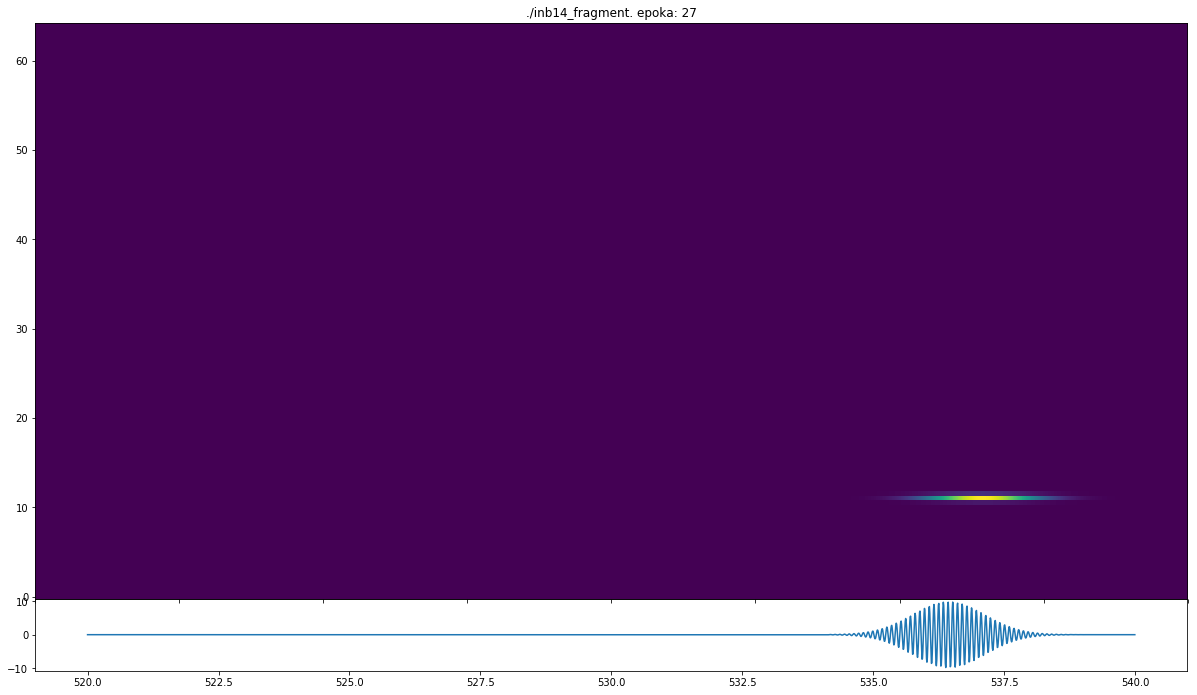

Epoka 28
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 540.0s - 560.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


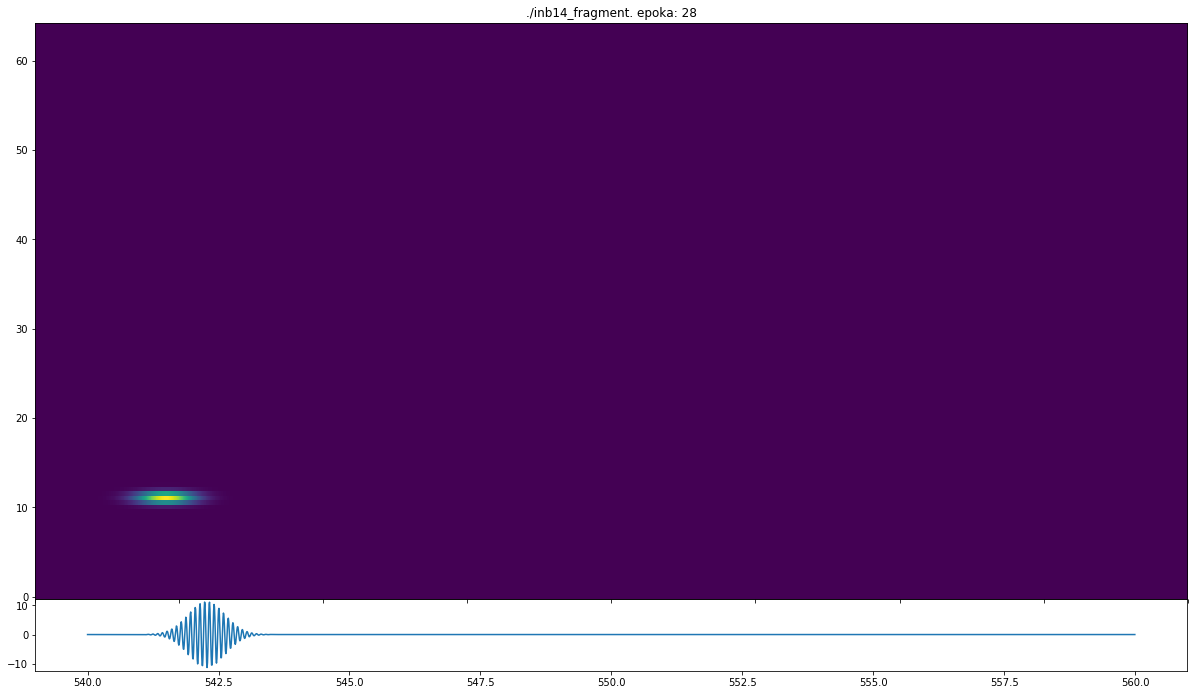

Epoka 29
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 560.0s - 580.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


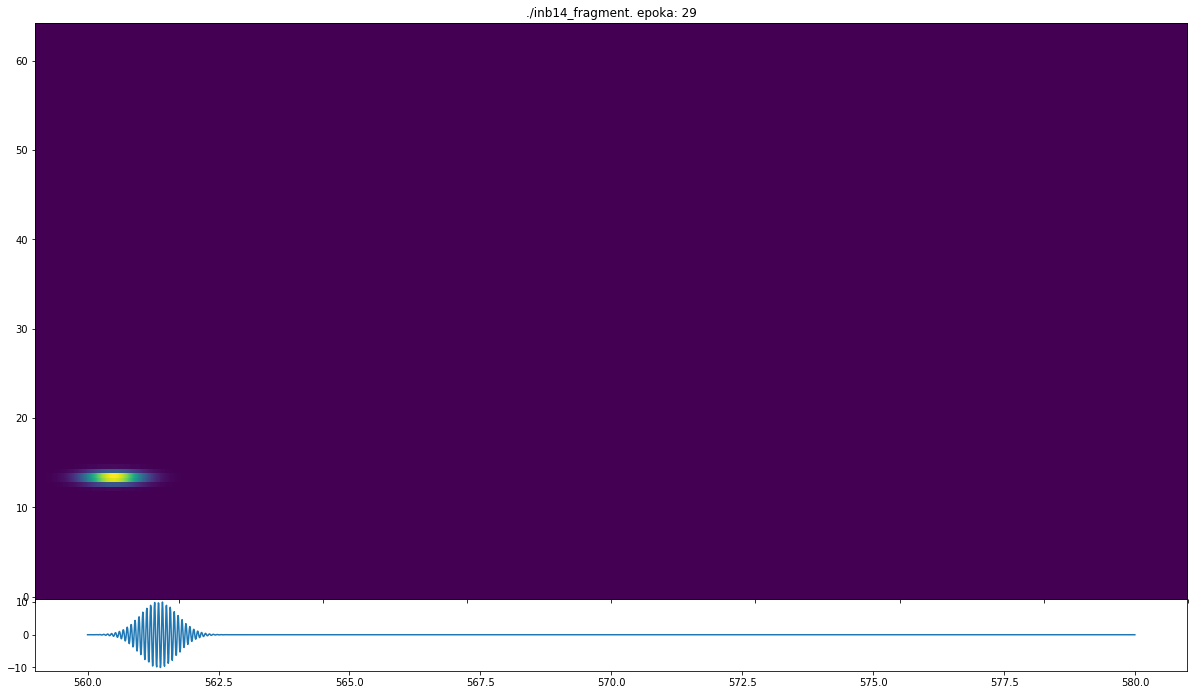

Epoka 30
Przedstawienie sygnału w przestrzeni czas częstość na przedziale 580.0s - 600.0s. Odrzucono wszystkie atomy, które nie zawierały się w paśmie 11Hz - 16Hz


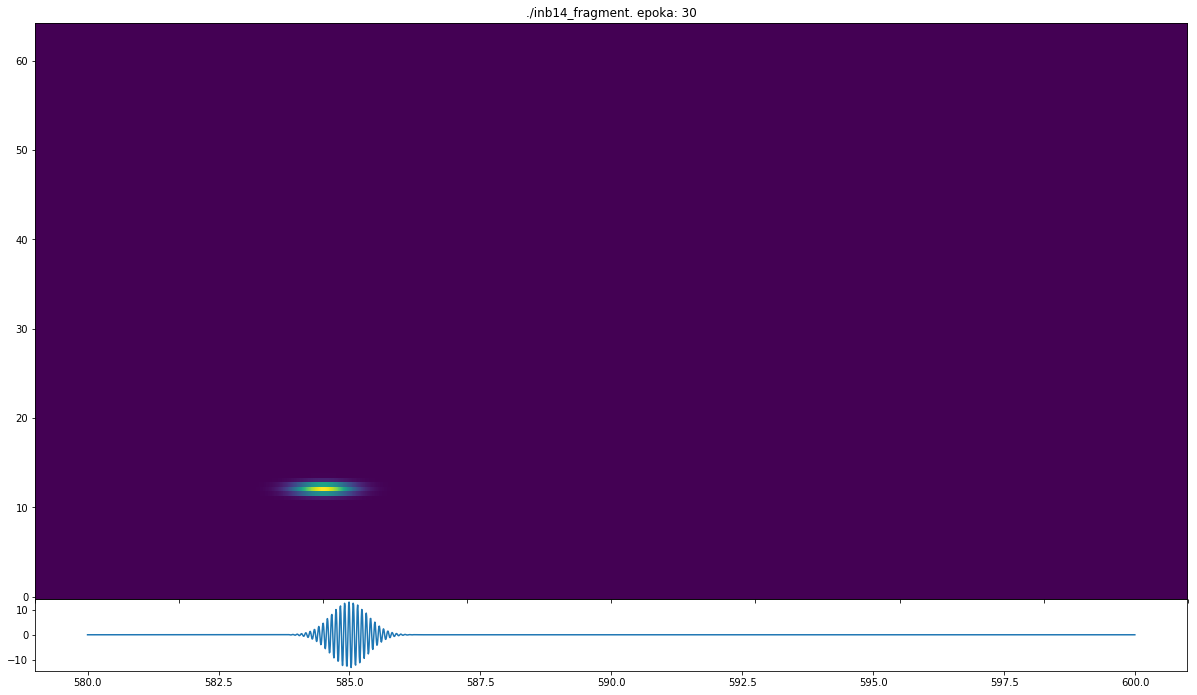

Start     ||       End
9.10      ||      9.98
22.25     ||     23.97
64.91     ||     66.64
102.06    ||    102.94
300.24    ||    301.12
358.42    ||    359.30
382.29    ||    383.17
535.57    ||    537.30
541.83    ||    542.71
560.92    ||    561.80
584.56    ||    585.44







Porównanie Metod
Wycinek sygnału 1
Wycinek sygnału okienowanego prostokątnie na przedziale 8.94s - 10.28s.
 Przedstawia wrzeciono znalezione przez MP i poprzez filtrowanie sygnału. Czerwony to przedział znaleziony przez Filtrowanie, a zielony to przedział znaleziony przez MP


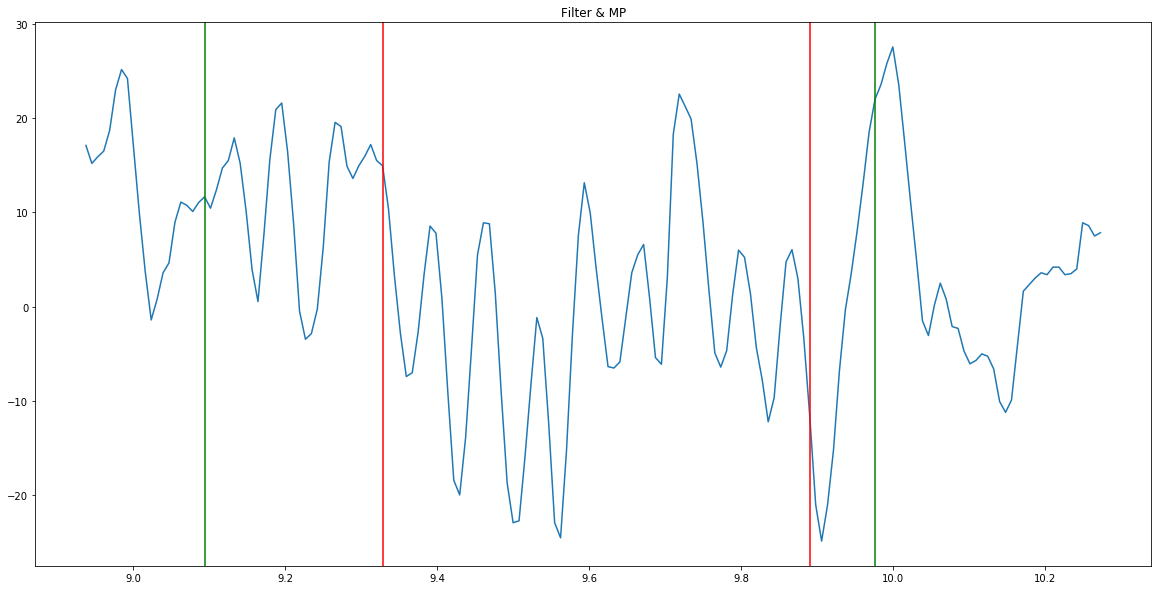

Wycinek sygnału 2
Wycinek sygnału okienowanego prostokątnie na przedziale 21.85s - 24.36s.
 Przedstawia wrzeciono znalezione przez samo MP.


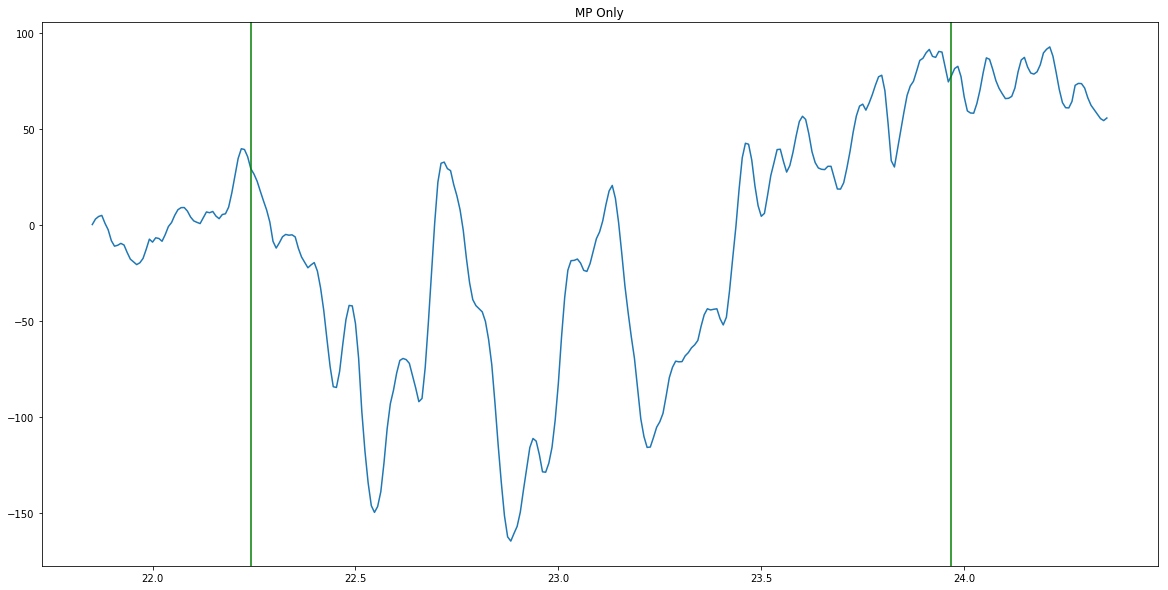

Wycinek sygnału 3
Wycinek sygnału okienowanego prostokątnie na przedziale 64.52s - 67.02s.
 Przedstawia wrzeciono znalezione przez samo MP.


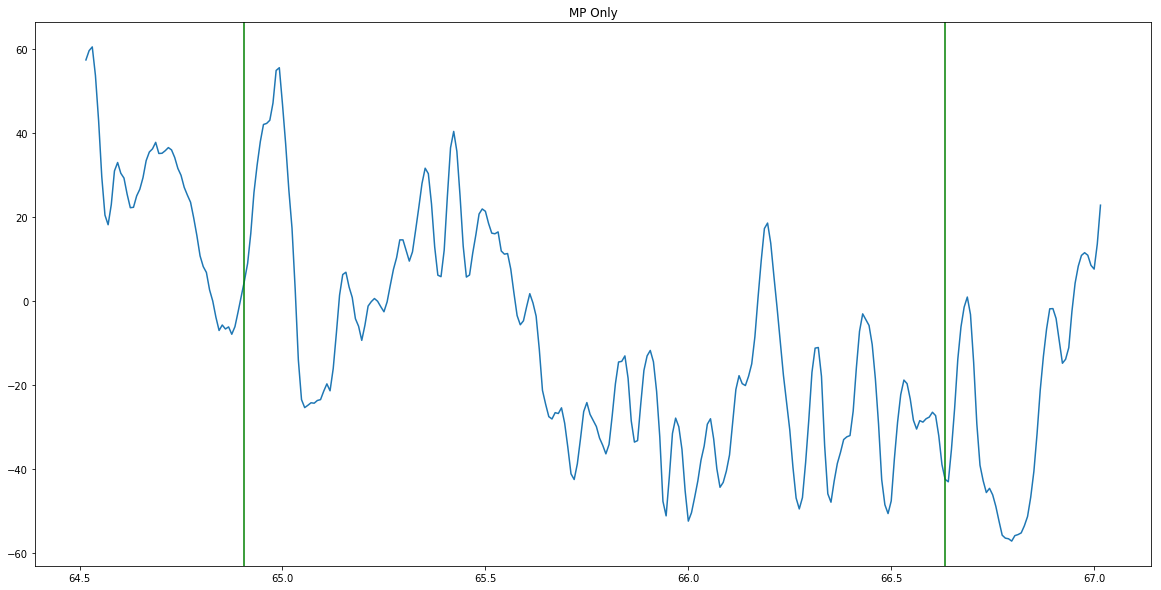

Wycinek sygnału 4
Wycinek sygnału okienowanego prostokątnie na przedziale 102.03s - 103.32s.
 Przedstawia wrzeciono znalezione przez MP i poprzez filtrowanie sygnału. Czerwony to przedział znaleziony przez Filtrowanie, a zielony to przedział znaleziony przez MP


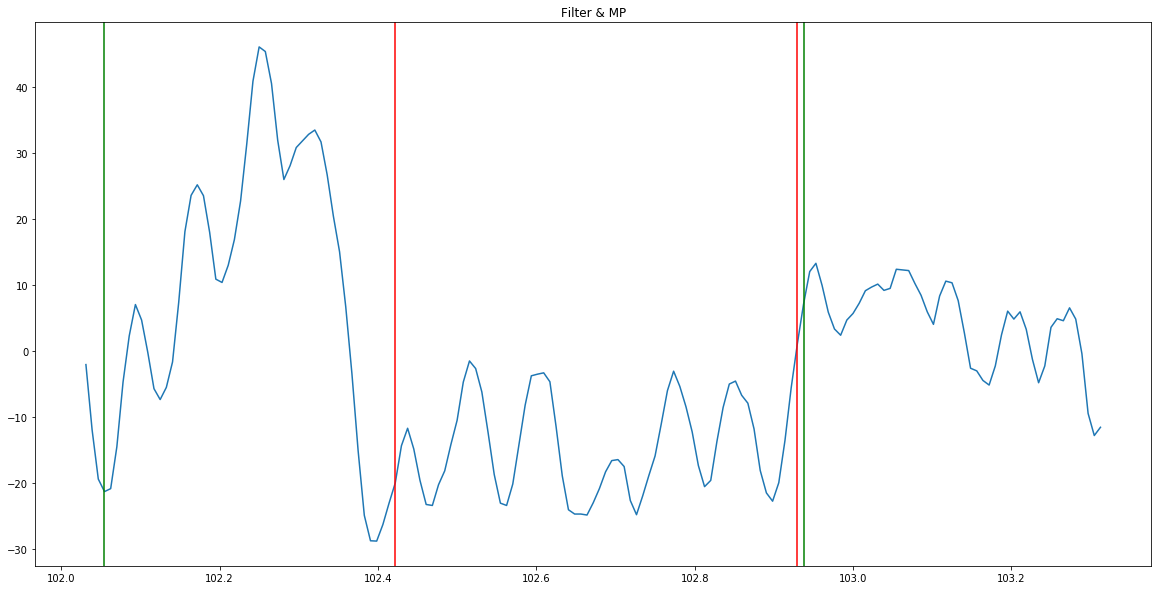

Wycinek sygnału 5
Wycinek sygnału okienowanego prostokątnie na przedziale 299.84s - 301.51s.
 Przedstawia wrzeciono znalezione przez samo MP.


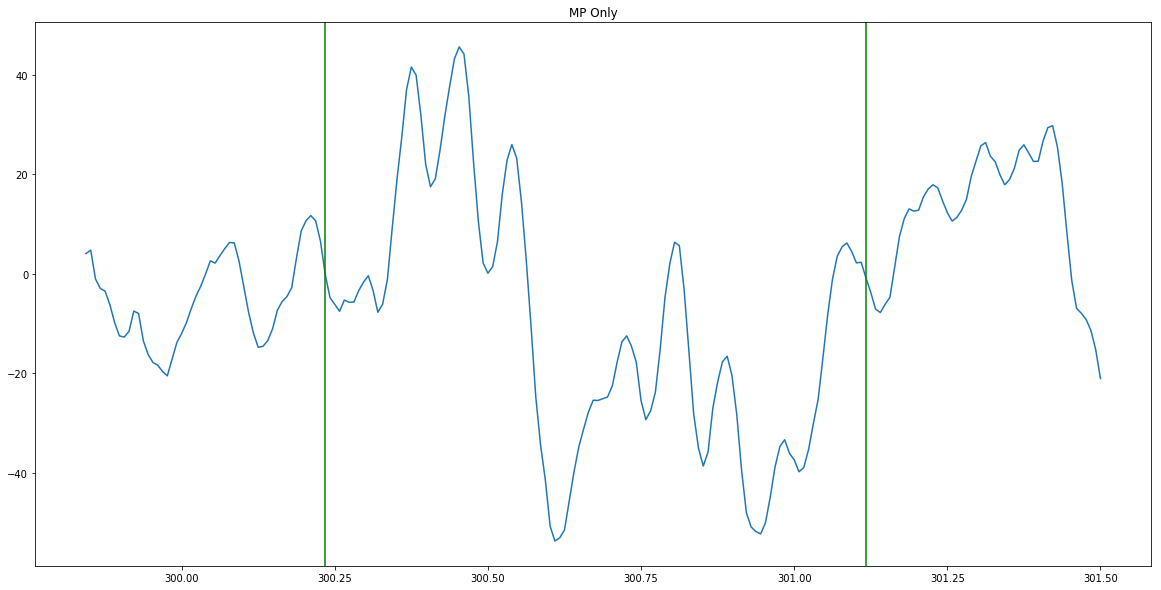

Wycinek sygnału 6
Wycinek sygnału okienowanego prostokątnie na przedziale 358.19s - 359.76s.
 Przedstawia wrzeciono znalezione przez MP i poprzez filtrowanie sygnału. Czerwony to przedział znaleziony przez Filtrowanie, a zielony to przedział znaleziony przez MP


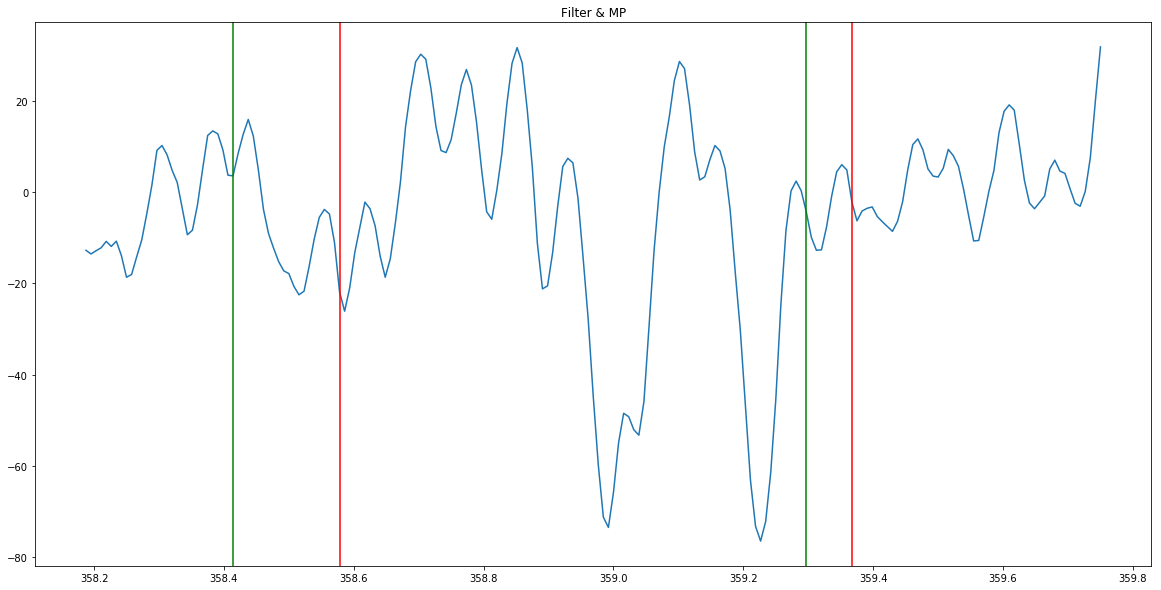

Wycinek sygnału 7
Wycinek sygnału okienowanego prostokątnie na przedziale 381.88s - 383.54s.
 Przedstawia wrzeciono znalezione przez MP i poprzez filtrowanie sygnału. Czerwony to przedział znaleziony przez Filtrowanie, a zielony to przedział znaleziony przez MP


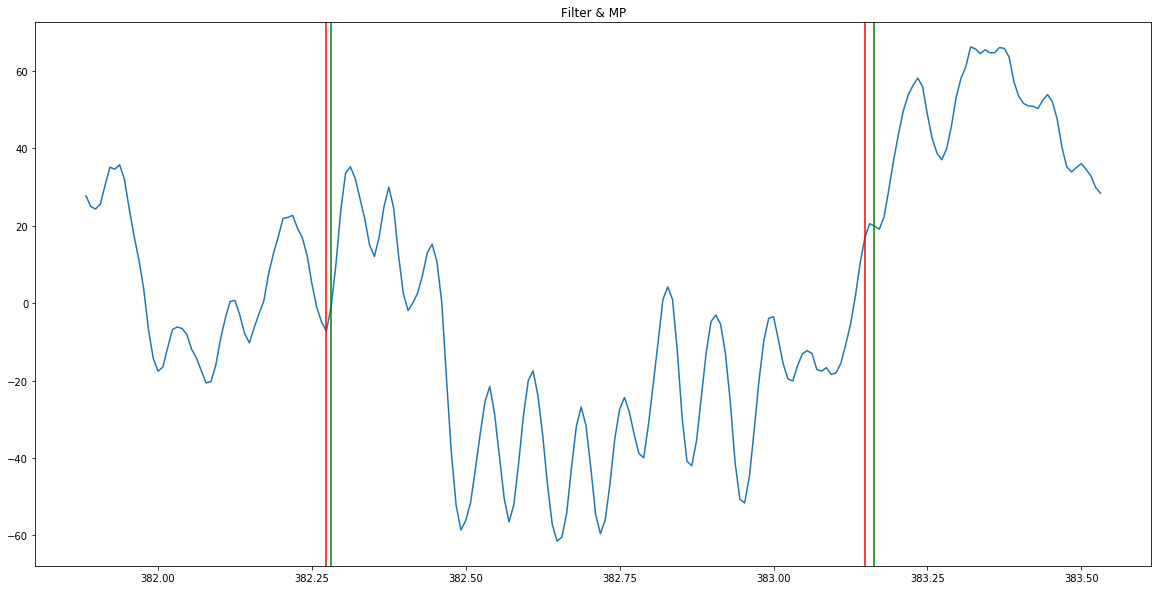

Wycinek sygnału 8
Wycinek sygnału okienowanego prostokątnie na przedziale 535.18s - 537.69s.
 Przedstawia wrzeciono znalezione przez samo MP.


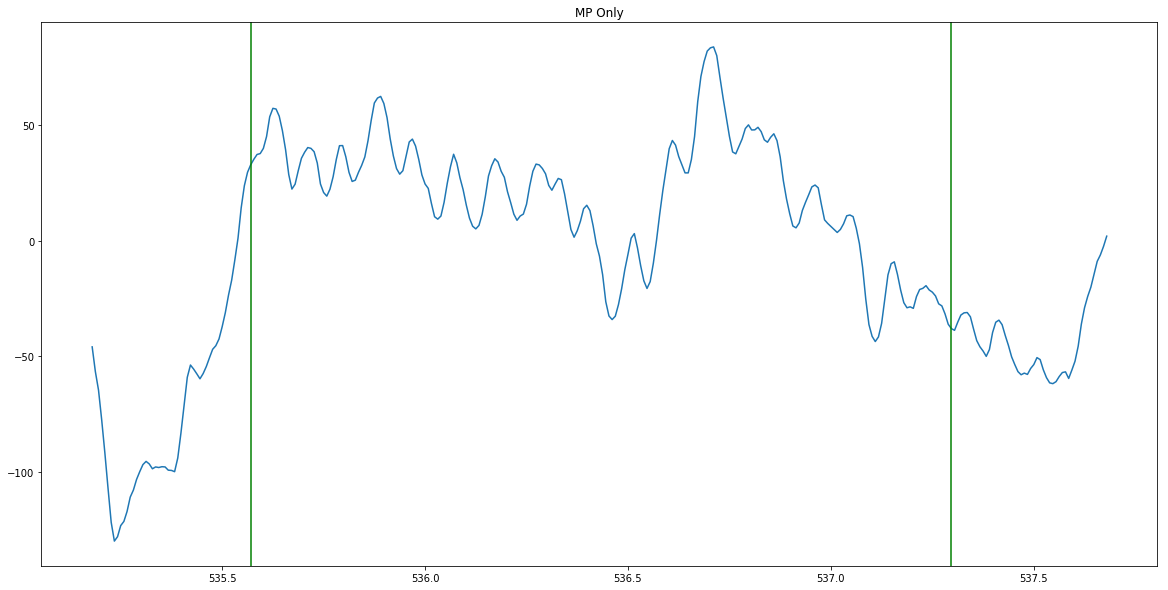

Wycinek sygnału 9
Wycinek sygnału okienowanego prostokątnie na przedziale 541.50s - 542.81s.
 Przedstawia wrzeciono znalezione przez MP i poprzez filtrowanie sygnału. Czerwony to przedział znaleziony przez Filtrowanie, a zielony to przedział znaleziony przez MP


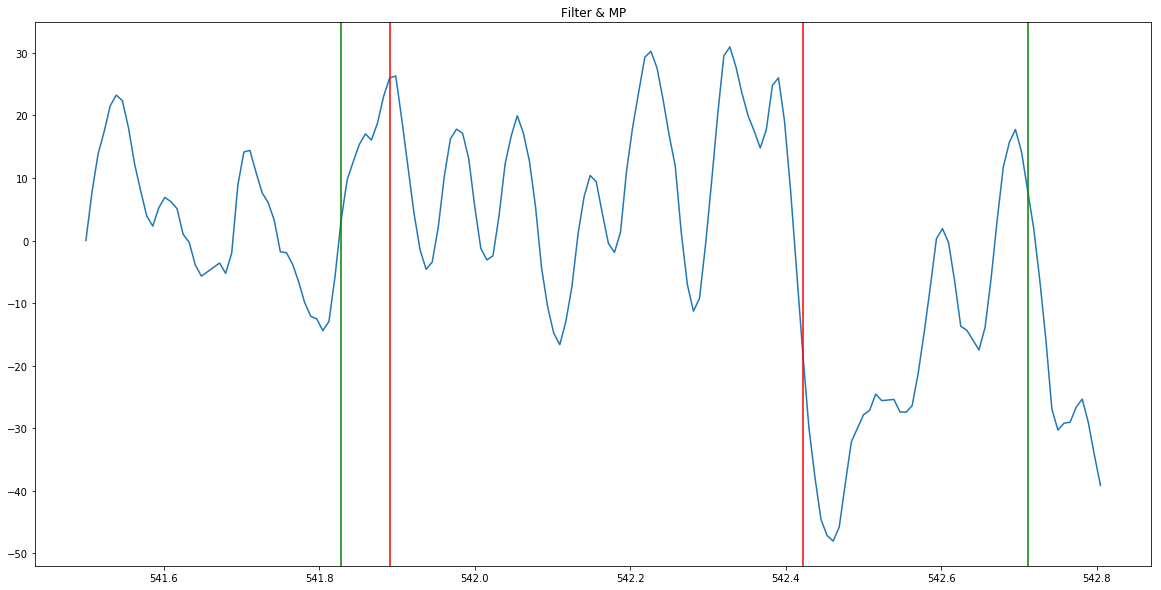

Wycinek sygnału 10
Wycinek sygnału okienowanego prostokątnie na przedziale 560.53s - 562.19s.
 Przedstawia wrzeciono znalezione przez samo MP.


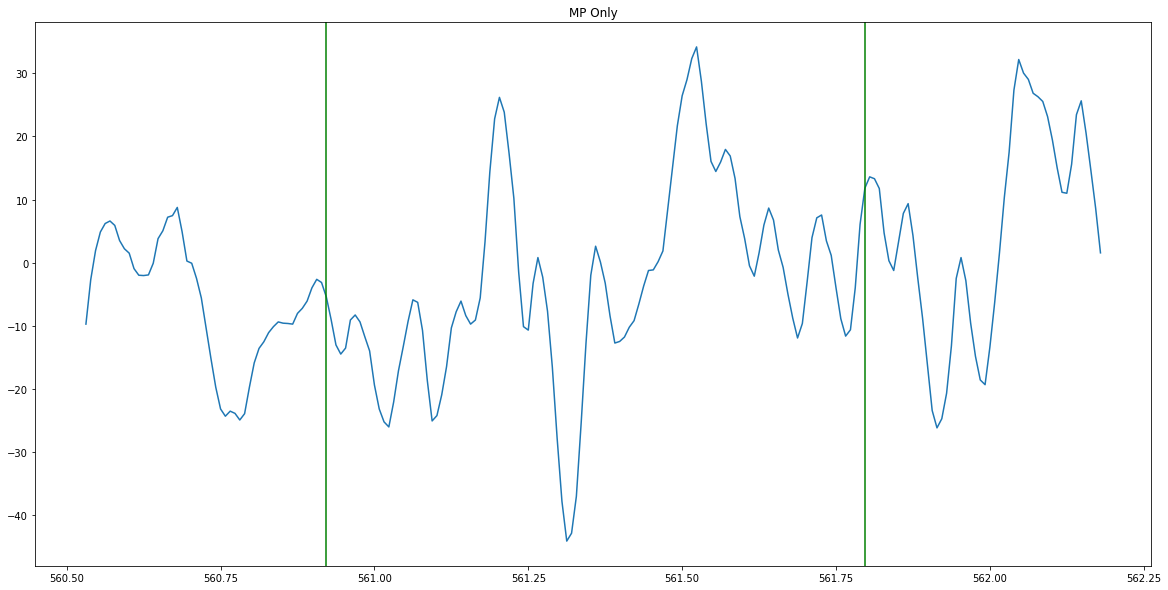

Wycinek sygnału 11
Wycinek sygnału okienowanego prostokątnie na przedziale 584.26s - 585.89s.
 Przedstawia wrzeciono znalezione przez MP i poprzez filtrowanie sygnału. Czerwony to przedział znaleziony przez Filtrowanie, a zielony to przedział znaleziony przez MP


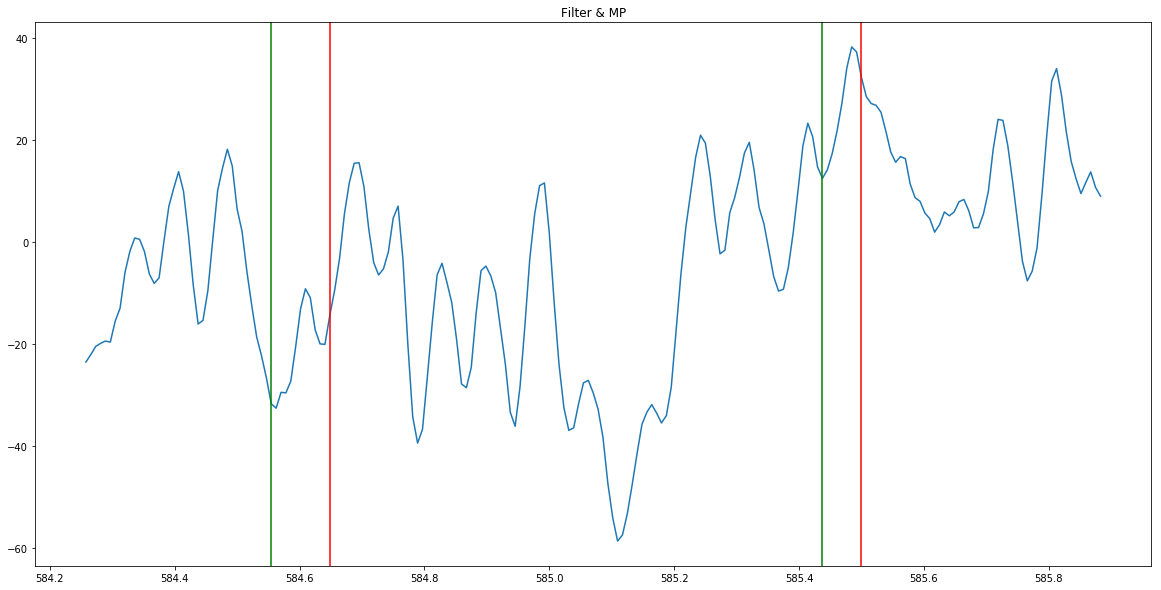

Wycinek sygnału 12
Wycinek sygnału okienowanego prostokątnie na przedziale 102.00s - 103.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


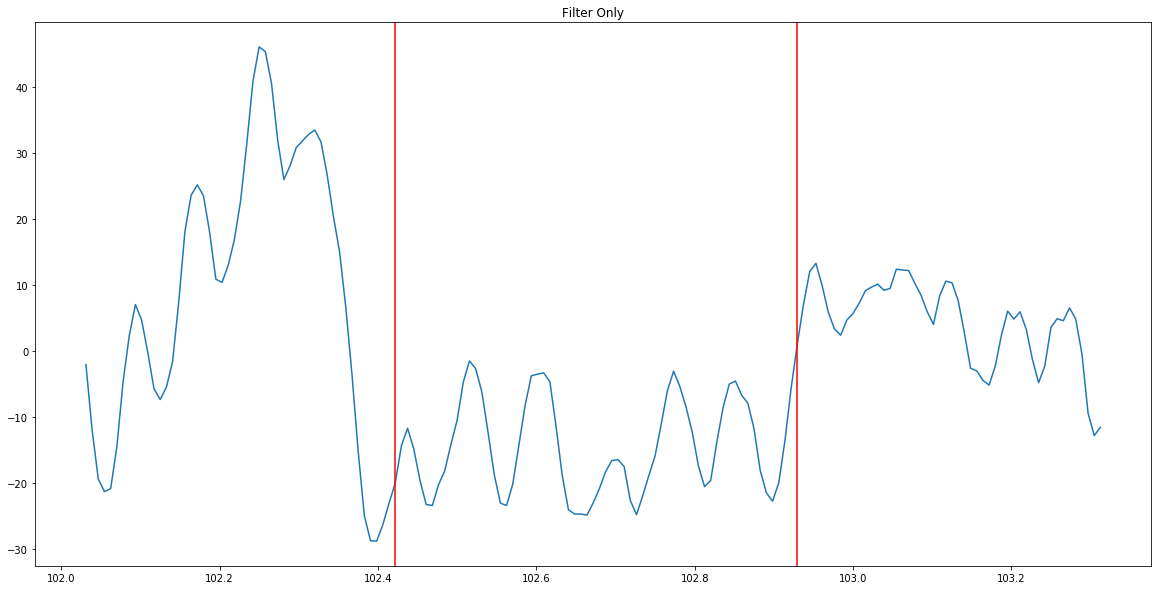

Wycinek sygnału 13
Wycinek sygnału okienowanego prostokątnie na przedziale 118.00s - 119.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


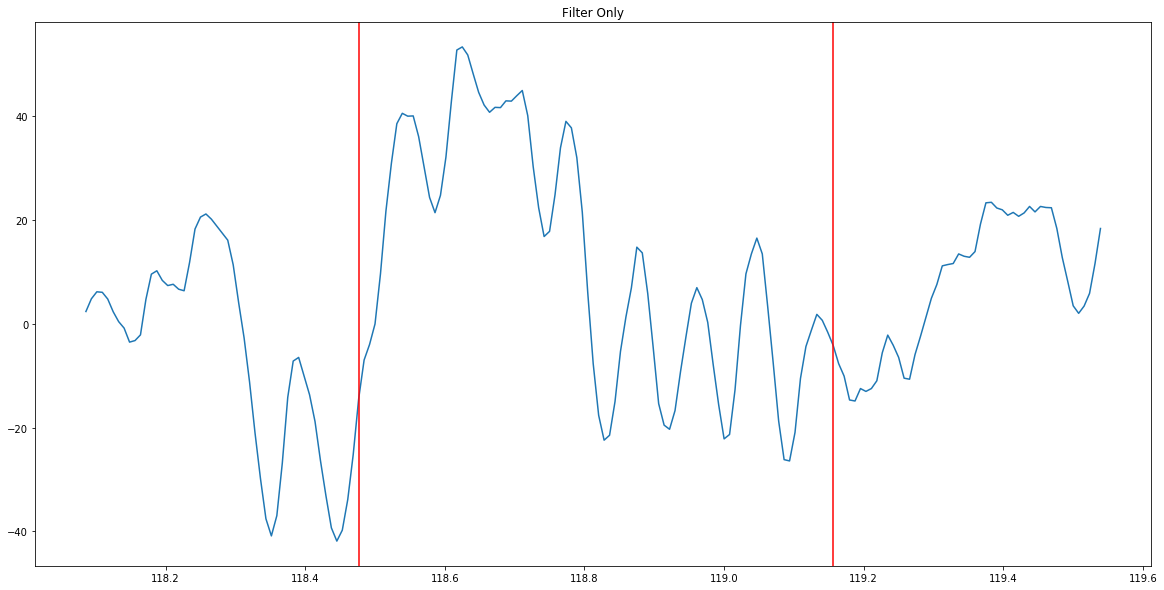

Wycinek sygnału 14
Wycinek sygnału okienowanego prostokątnie na przedziale 221.00s - 222.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


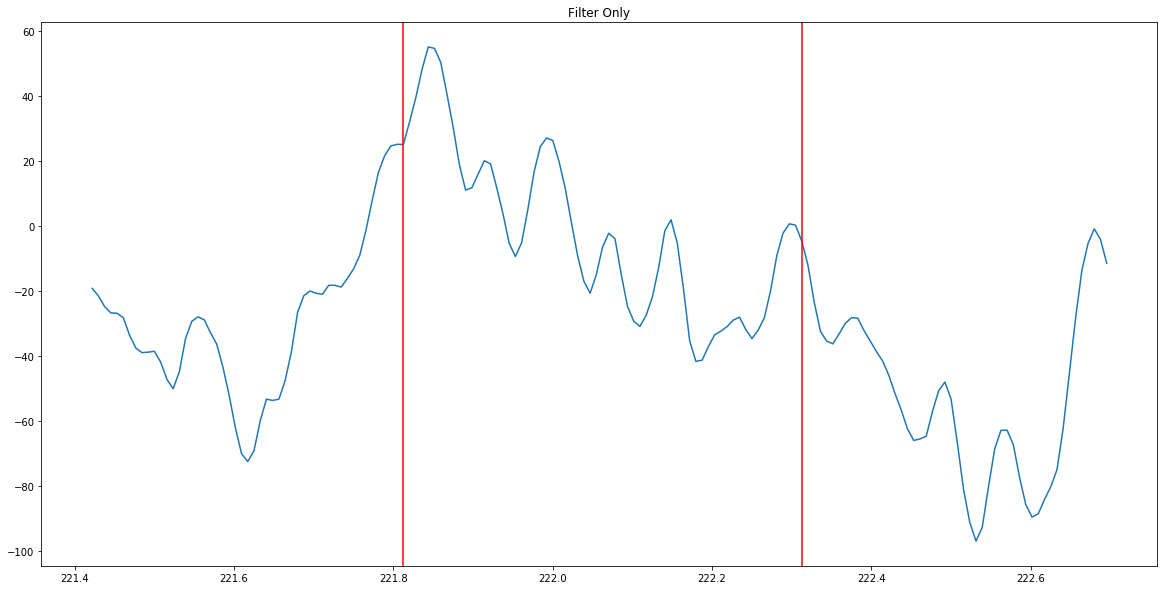

Wycinek sygnału 15
Wycinek sygnału okienowanego prostokątnie na przedziale 330.00s - 332.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


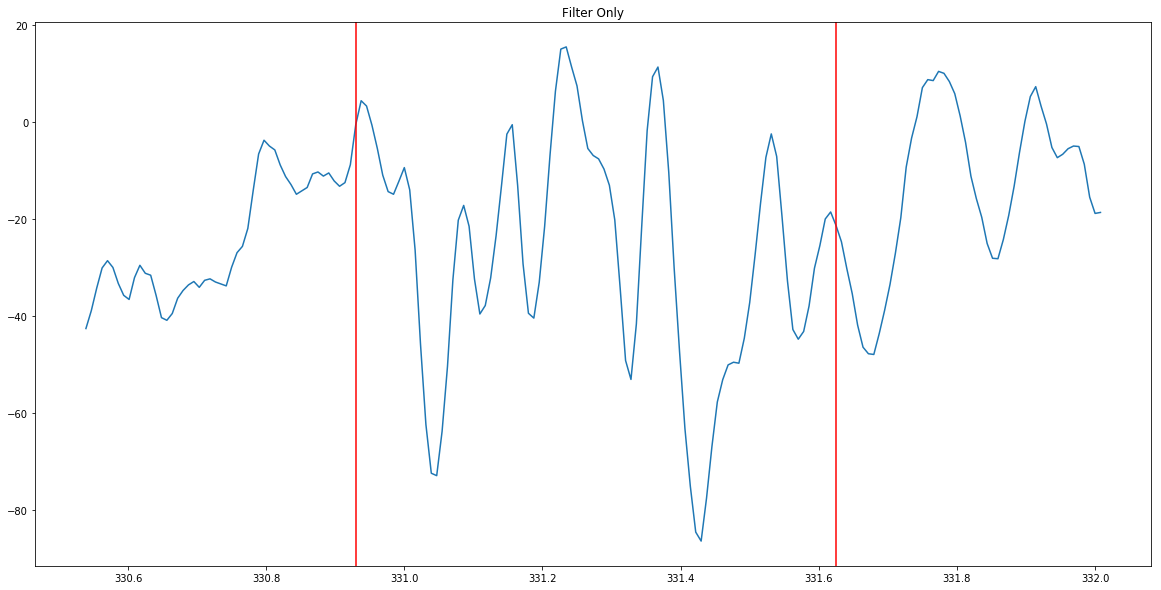

Wycinek sygnału 16
Wycinek sygnału okienowanego prostokątnie na przedziale 355.00s - 357.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


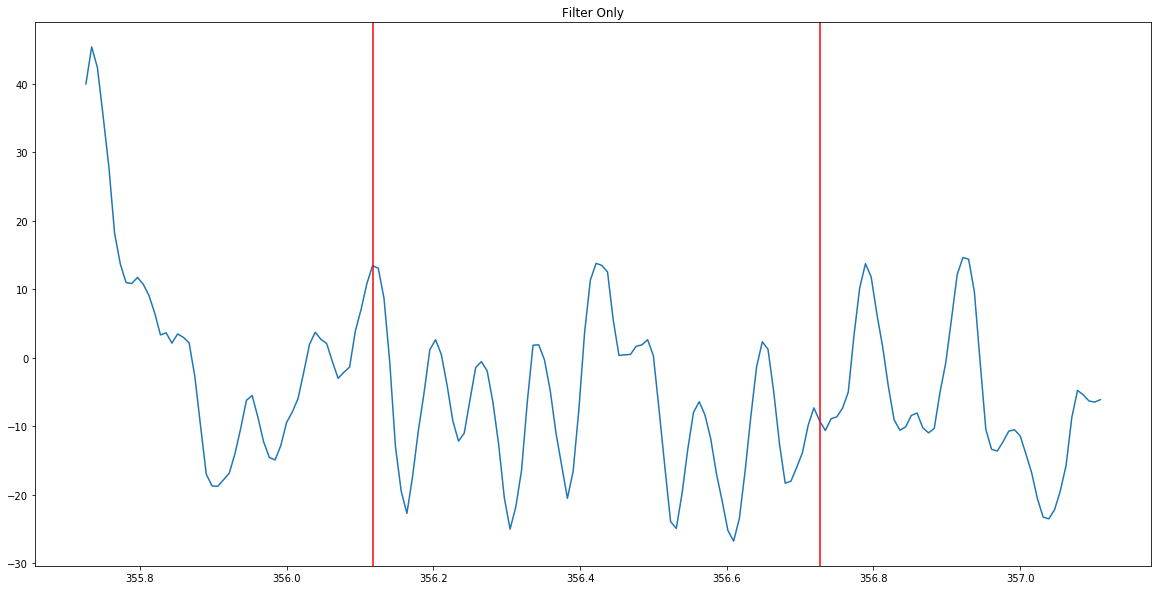

Wycinek sygnału 17
Wycinek sygnału okienowanego prostokątnie na przedziale 368.00s - 369.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


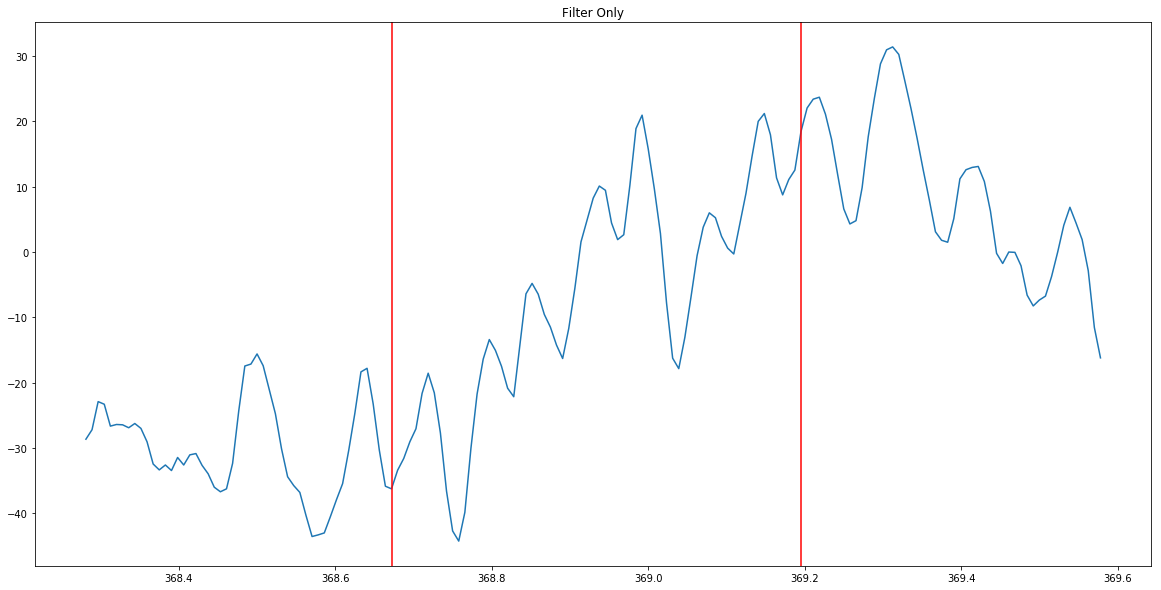

Wycinek sygnału 18
Wycinek sygnału okienowanego prostokątnie na przedziale 381.00s - 383.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


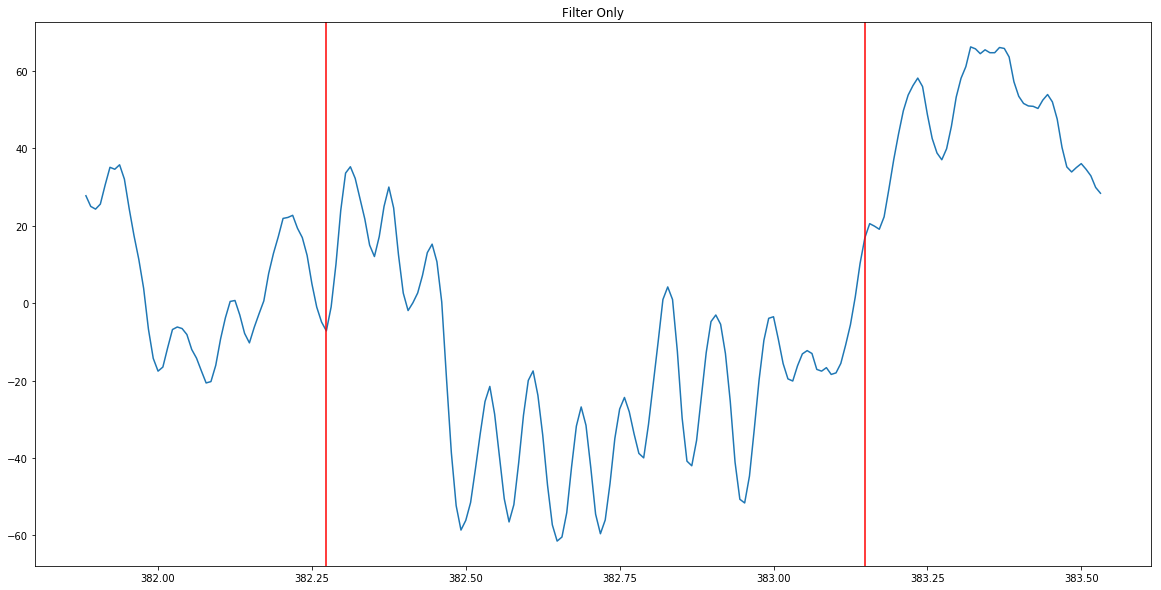

Wycinek sygnału 19
Wycinek sygnału okienowanego prostokątnie na przedziale 389.00s - 390.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


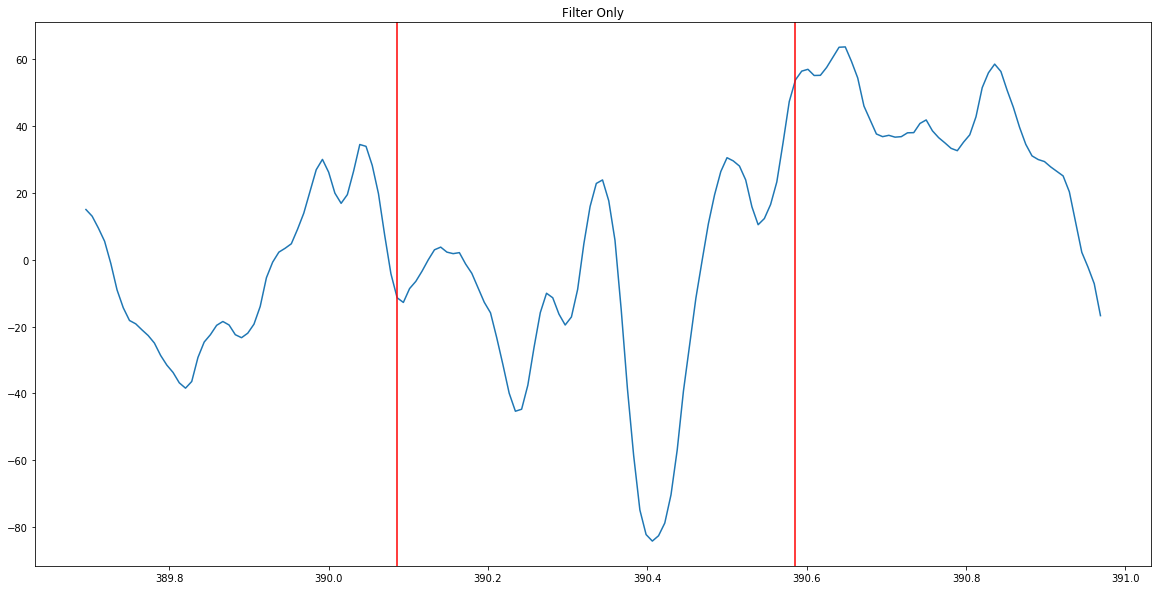

Wycinek sygnału 20
Wycinek sygnału okienowanego prostokątnie na przedziale 394.00s - 396.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


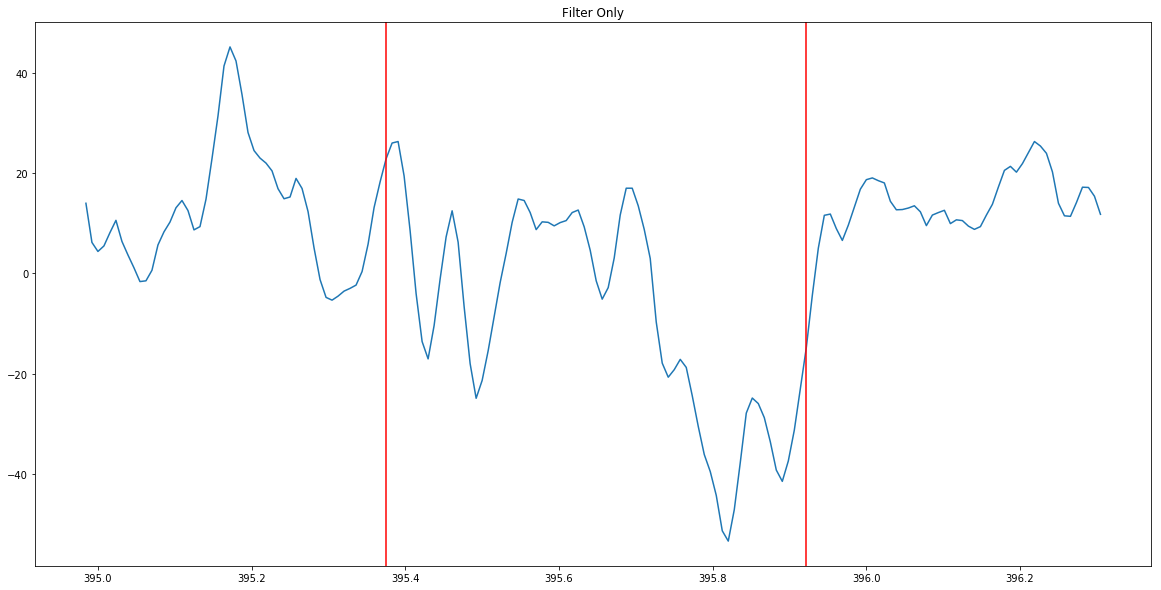

Wycinek sygnału 21
Wycinek sygnału okienowanego prostokątnie na przedziale 424.00s - 426.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


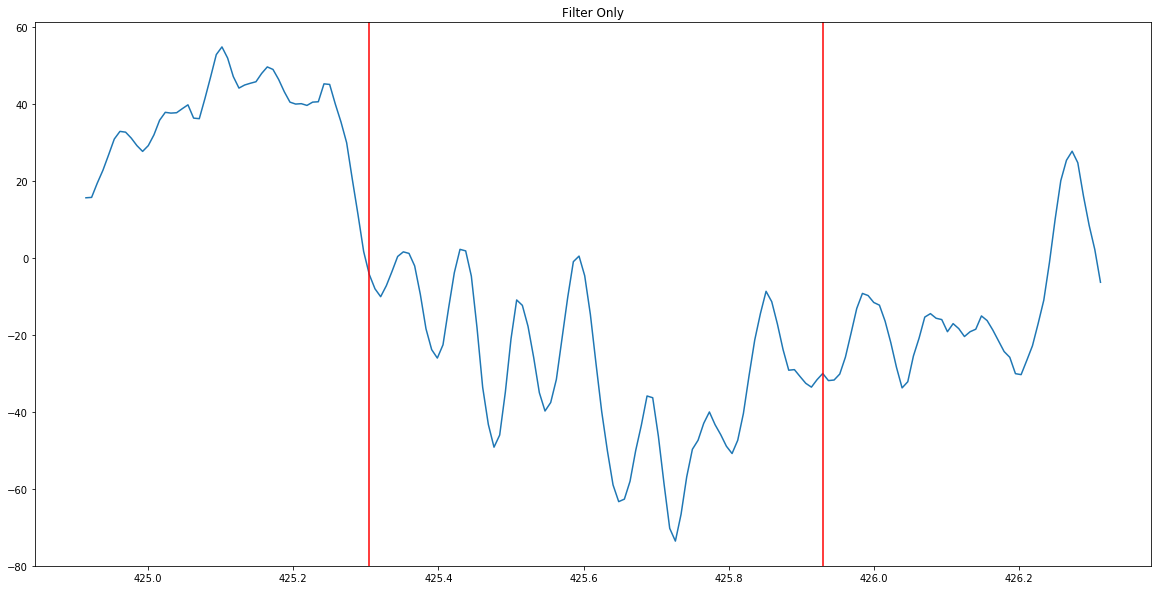

Wycinek sygnału 22
Wycinek sygnału okienowanego prostokątnie na przedziale 457.00s - 458.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


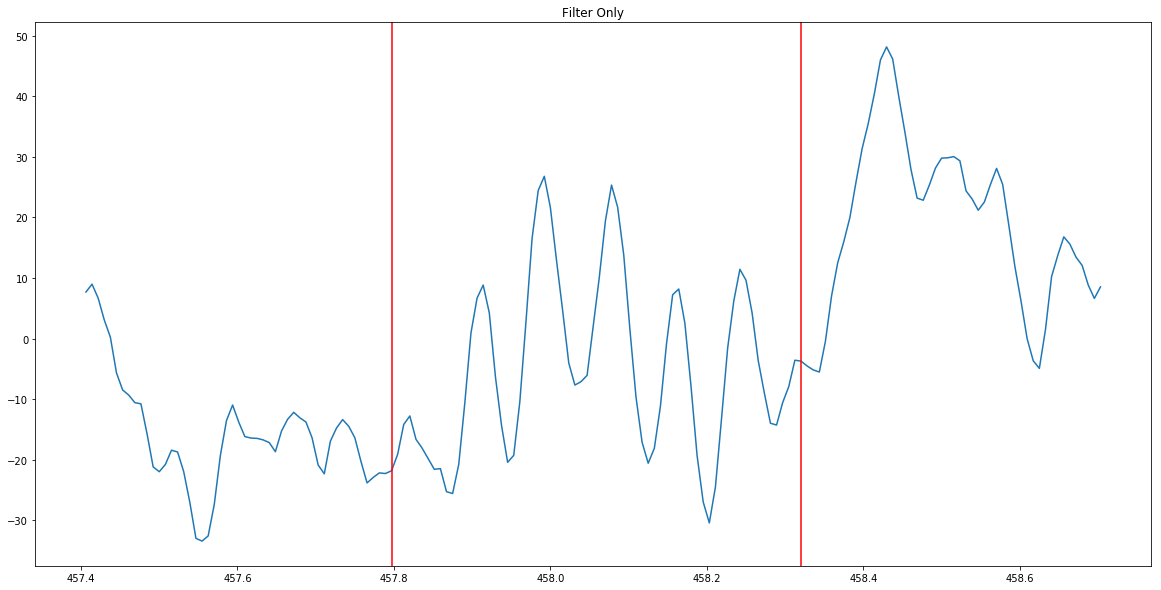

Wycinek sygnału 23
Wycinek sygnału okienowanego prostokątnie na przedziale 489.00s - 490.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


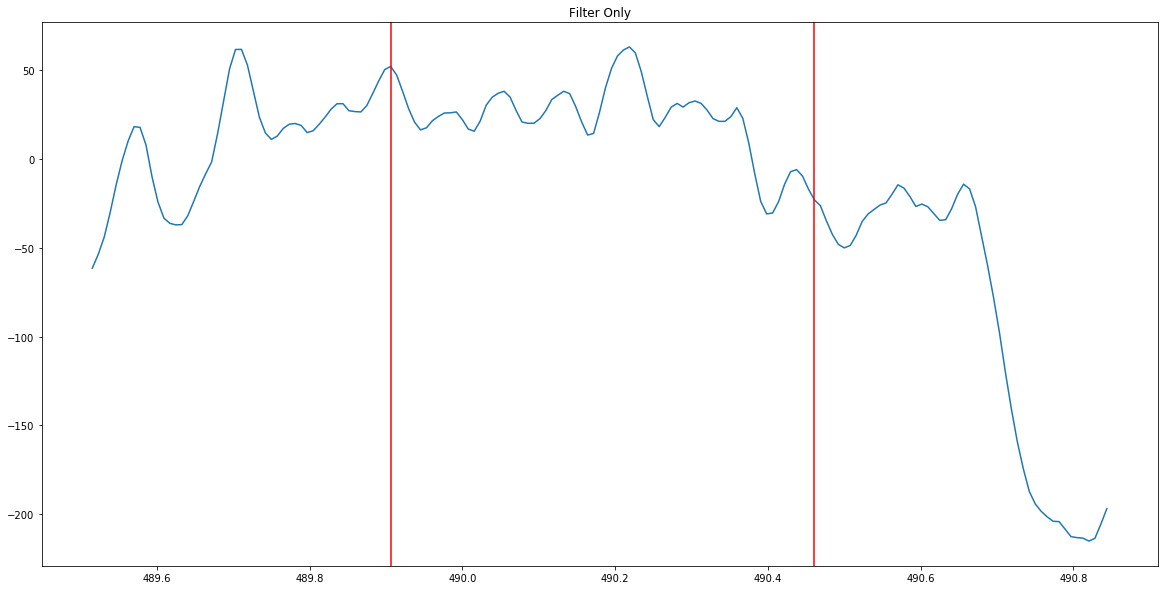

Wycinek sygnału 24
Wycinek sygnału okienowanego prostokątnie na przedziale 503.00s - 504.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


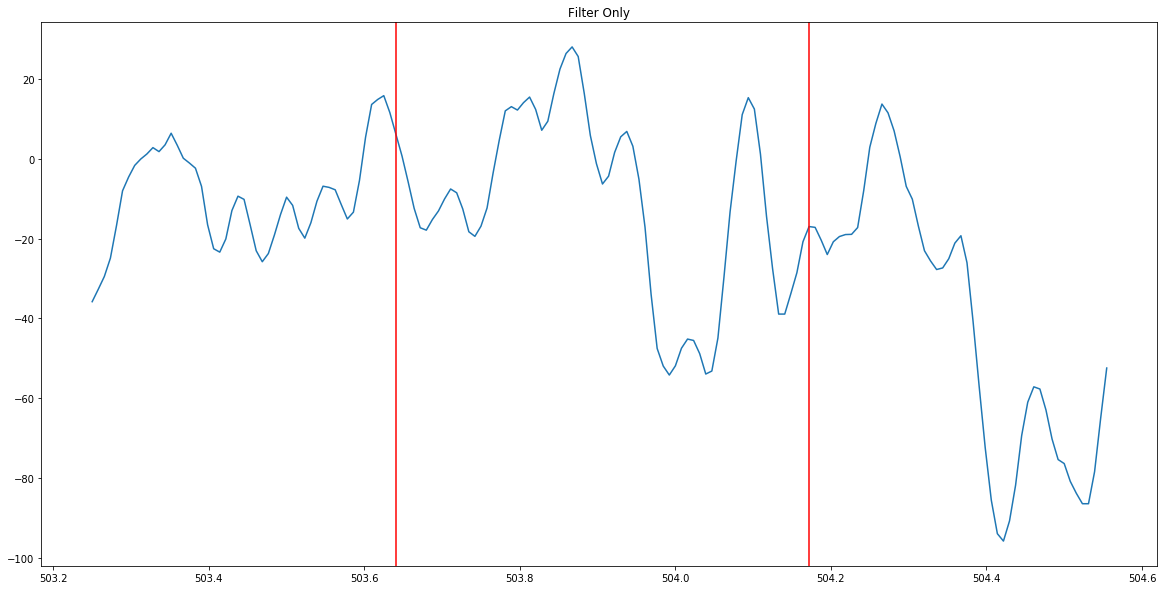

Wycinek sygnału 25
Wycinek sygnału okienowanego prostokątnie na przedziale 507.00s - 509.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


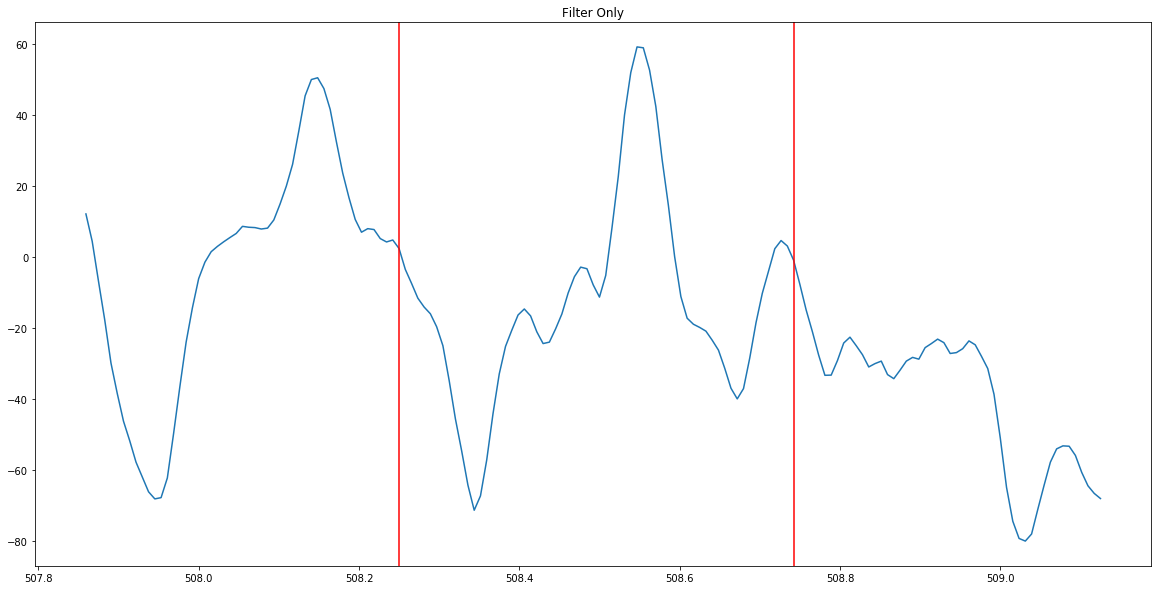

Wycinek sygnału 26
Wycinek sygnału okienowanego prostokątnie na przedziale 541.00s - 542.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


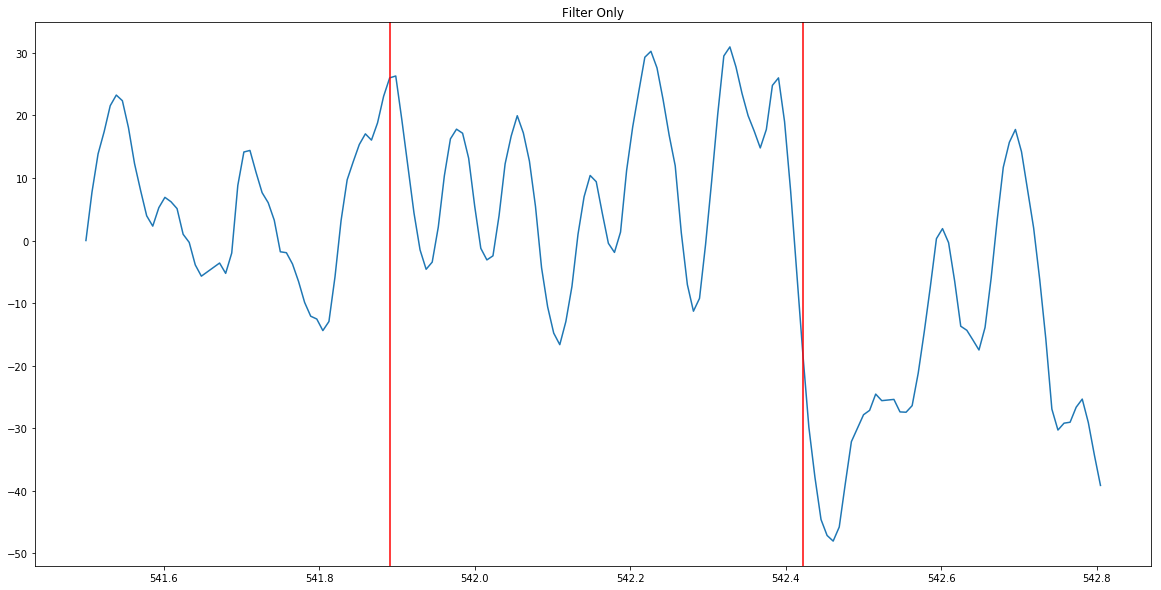

Wycinek sygnału 27
Wycinek sygnału okienowanego prostokątnie na przedziale 551.00s - 553.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


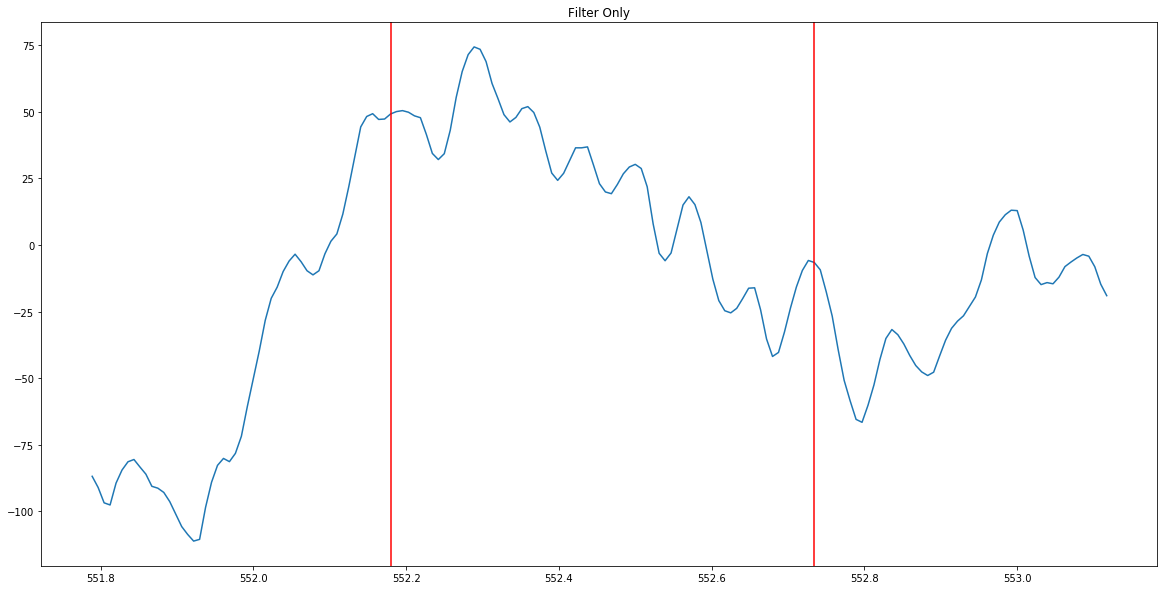

Wycinek sygnału 28
Wycinek sygnału okienowanego prostokątnie na przedziale 584.00s - 585.00s.
 Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.


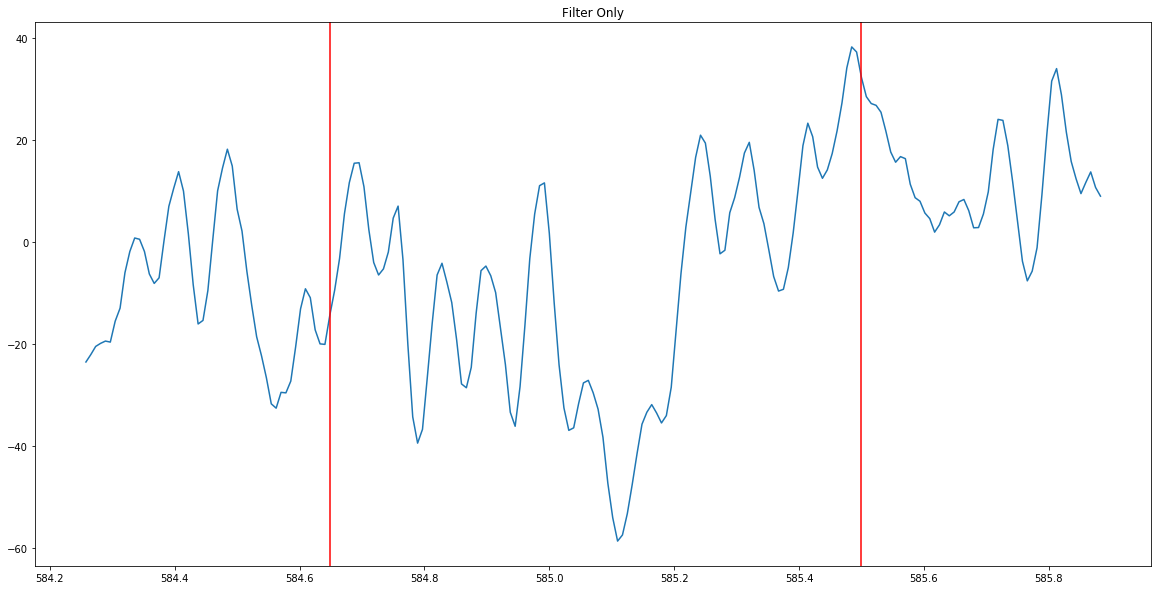

Porównanie i Analiza

Jak widać na podstawie powyższych wykresów metoda filtrowania znalazła znacznie więcej wrzecion. Jest to spowodowane charakterystyką obu metod. Jak wiadomo filtry nie są perfekcyjne i nie odcinamy “schodkowo” częstości, a raczej wykorzystujemy krzywą. Takie filtry wycinają trochę częstotliwości poniżej pożądanej częstości (w przypadku filtrów dolnoprzepustowych) i pozostawiają trochę częstości powyżej. W wyniku tego pozostają struktury, które mają podobną częstotliwość do częstotliwości, w których odcinaliśmy oraz ich moc może być na tyle duża, że przekroczą 5mV. Z tego powodu pojawią się dodatkowe wrzeciona spoza przedziału 11 Hz - 16Hz. Dodatkowo metoda MP jest dużo bardziej bezwzględna i nie pozwala by struktury o częstotliwości poza tego pasma były przepuszczane. Pytanie, czy wrzeciona faktycznie powinny być odcinane tak bezwględnie? Może MP powinno odcinać w trochę szerszym przedziale? Ponadto MP tłumaczy tylko część energii (tu 95%). Część z tych wrzecion, k

In [22]:

Fs = 128
signal = Signal('./inb14_fragment.bin', 128)
t = signal.t
s = signal.s
# signal.plot_signal()
filt_spindles = signal.filt_classifier()
mp_spindles = signal.mp_classifier(50, 0.1)

print("Porównanie Metod")
covering = []
for index, i in enumerate(mp_spindles):
    low = abs(np.array(filt_spindles)[:, 0] - i[0])
    if low[np.where(low == min(low))[0][0]] <= 0.5:
        covering.append([np.where(low == min(low))[0][0], index])  # [filt, mp]
covering = np.array(covering)
c_index = 0
for index, i in enumerate(mp_spindles):
    plt.figure(figsize=((20, 10)))
    if index in covering[:, 1]:
        where = np.where(covering[:, 1] == index)[0][0]
        l = ((np.array(filt_spindles[covering[where][0]]) * Fs).astype('int'),
             (np.array(mp_spindles[covering[where][1]]) * Fs).astype('int'))
        plt.plot(t[l[0][0] - 50:l[0][1] + 50], s[l[0][0] - 50:l[0][1] + 50])
        plt.axvline(t[l[0][0]], c='r')
        plt.axvline(t[l[0][1]], c='r')
        plt.axvline(t[l[1][0]], c='g')
        plt.axvline(t[l[1][1]], c='g')
        plt.title('Filter & MP')
        c_index += 1
        print("Wycinek sygnału {}".format(c_index) + "\n" +
                     u"Wycinek sygnału okienowanego prostokątnie na przedziale {:.2f}s - {:.2f}s.\n Przedstawia wrzeciono znalezione przez MP i poprzez filtrowanie sygnału. Czerwony to przedział znaleziony przez Filtrowanie, a zielony to przedział znaleziony przez MP".format(
                         ((l[0][0] - 50) / Fs), ((l[0][1] + 50)) / Fs))
        plt.show()
    else:
        l = (np.array(i) * Fs).astype('int')
        plt.plot(t[l[0] - 50:l[1] + 50], s[l[0] - 50:l[1] + 50])
        plt.axvline(t[l[0]], c='g')
        plt.axvline(t[l[1]], c='g')
        plt.title('MP Only')
        c_index += 1
        print("Wycinek sygnału {}\n".format(c_index) +
                 u"Wycinek sygnału okienowanego prostokątnie na przedziale {:.2f}s - {:.2f}s.\n Przedstawia wrzeciono znalezione przez samo MP.".format(
                     (l[0] - 50) / Fs, (l[1] + 50) / Fs))
        plt.show()
for index, i in enumerate(filt_spindles):
    if index in covering[:, 1]:
        pass
    else:
        plt.figure(figsize=((20, 10)))
        l = (np.array(i) * Fs).astype('int')
        plt.plot(t[l[0] - 50:l[1] + 50], s[l[0] - 50:l[1] + 50])
        plt.axvline(t[l[0]], c='r')
        plt.axvline(t[l[1]], c='r')
        plt.title('Filter Only')
        c_index += 1
        print("Wycinek sygnału {}\n".format(c_index) +
                     u"Wycinek sygnału okienowanego prostokątnie na przedziale {:.2f}s - {:.2f}s.\n Przedstawia wrzeciono znalezione poprzez samo filtrowanie sygnału.".format(
                         int((l[0] - 50) / 128), int((l[1] + 50) / 128)))
        plt.show()
print("Porównanie i Analiza")
explanation = '''
Jak widać na podstawie powyższych wykresów metoda filtrowania znalazła znacznie więcej wrzecion. Jest to spowodowane charakterystyką obu metod. Jak wiadomo filtry nie są perfekcyjne i nie odcinamy “schodkowo” częstości, a raczej wykorzystujemy krzywą. Takie filtry wycinają trochę częstotliwości poniżej pożądanej częstości (w przypadku filtrów dolnoprzepustowych) i pozostawiają trochę częstości powyżej. W wyniku tego pozostają struktury, które mają podobną częstotliwość do częstotliwości, w których odcinaliśmy oraz ich moc może być na tyle duża, że przekroczą 5mV. Z tego powodu pojawią się dodatkowe wrzeciona spoza przedziału 11 Hz - 16Hz. Dodatkowo metoda MP jest dużo bardziej bezwzględna i nie pozwala by struktury o częstotliwości poza tego pasma były przepuszczane. Pytanie, czy wrzeciona faktycznie powinny być odcinane tak bezwględnie? Może MP powinno odcinać w trochę szerszym przedziale? Ponadto MP tłumaczy tylko część energii (tu 95%). Część z tych wrzecion, które zostały wykryte przez filtrowanie mogło się zawierać w tych 5% nie wytłumaczonych. W wyniku tych charakterystyk podejrzewamy pojawienie się wrzecion wykrytych tylko przez filtrowanie.
'''
print(explanation)
explanation = '''
Pozostają jeszcze te wykryte tylko przez MP. Podobnie jak w poprzednim przypadku, filtr jako nie idealna struktura usuwa także część częstości, które nas interesują. W wyniku tego niektóre wrzeciona mogą zniknąć lub zostać mocno osłabione, przez zostaną pominięte przez 1 metodę.
'''
print(explanation)